# Section3-5: Complex Internet network analysis

Analysis of the 2020-01-01 pDB c-graph

Recquire the compilation of pygomax submodule:
- `git clone --recursive https://github.com/JustinLoye/pygomax`
- `cd pygomax`
- `mkdir build`
- `cd build`
- `cmake ..`
- `make`

In a first part, we show the properties of 2020/01/01 snapshot. 
We identify key Internet players. First hypergiants and then with a clustering technique regional eyeball networks. This set of players is used as the reduced nodes, an input for section6

# Network study for standard setting $\beta_H=0.95$ $\beta_M=0.75$  

required modules

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import pickle


from tqdm import tqdm ##not mandatory, only for cosmetic use
from scipy.optimize import curve_fit
import networkx as nx
from pygomax import pygomax

import matplotlib.ticker

loading january data

In [2]:
prefix = "peeringdb_2_dump_"
date = "2020_01_01"

pickle_in = open("caida_pdbs/processed/nodes/"+prefix+date+".pickle", "rb")
nodes_jan = pickle.load(pickle_in)
pickle_in.close()
nodes_jan = nodes_jan.loc[nodes_jan["port_capacity"]>0]

pickle_in = open("caida_pdbs/processed/ix/"+prefix+date+".pickle", "rb")
ix_jan = pickle.load(pickle_in)
pickle_in.close()
ix_jan = ix_jan.loc[ix_jan["port_capacity"]>0]

pickle_in = open("caida_pdbs/processed/net/"+prefix+date+".pickle", "rb")
net_jan = pickle.load(pickle_in)
pickle_in.close()
net_jan = net_jan.loc[net_jan["port_capacity"]>0]

BETA_H = 0.95
BETA_M = 0.75

edgelist = open("caida_pdbs/processed/graph/"+format(BETA_H, '.4f')+"_"+format(BETA_M, '.4f')+"_"+prefix+date+".txt", "r")
DiGraph_jan = nx.parse_edgelist(edgelist, nodetype = int, data=(('weight',float),), create_using = nx.DiGraph, delimiter=",")

## General info on january 2020 snapshot

In [3]:
print("Number of nodes: ", len(DiGraph_jan))
print("Number of links: ", len(DiGraph_jan.edges()))
print("Number of ASes: ", len(net_jan))
print("Number of IXPS: ", len(ix_jan))
print("Number of IXPS with at least 3 participants: ", len(ix_jan.loc[ix_jan.net_count>=3]))

Number of nodes:  10381
Number of links:  52422
Number of ASes:  9695
Number of IXPS:  686
Number of IXPS with at least 3 participants:  588


## General info for 2022

In [4]:
prefix = "peeringdb_2_dump_"
date = "2021_12_30"

pickle_in = open("../test/caida_pdbs/processed/nodes/"+prefix+date+".pickle", "rb")
nodes = pickle.load(pickle_in)
pickle_in.close()
nodes = nodes.loc[nodes["port_capacity"]>0]

pickle_in = open("../test/caida_pdbs/processed/ix/"+prefix+date+".pickle", "rb")
ix = pickle.load(pickle_in)
pickle_in.close()
ix = ix.loc[ix["port_capacity"]>0]

pickle_in = open("../test/caida_pdbs/processed/net/"+prefix+date+".pickle", "rb")
net = pickle.load(pickle_in)
pickle_in.close()
print(len(net))
net = net.loc[net["port_capacity"]>0]
print(len(net))

BETA_H = 0.95
BETA_M = 0.75

edgelist = open("../test/caida_pdbs/processed/graph/"+format(BETA_H, '.4f')+"_"+format(BETA_M, '.4f')+"_"+prefix+date+".txt", "r")
DiGraph = nx.parse_edgelist(edgelist, nodetype = int, data=(('weight',float),), create_using = nx.DiGraph, delimiter=",")

12992
12689


In [5]:
print("Number of nodes: ", len(DiGraph))
print("Number of links: ", len(DiGraph.edges()))
print("Number of ASes: ", len(net))
print("Number of IXPS: ", len(ix))
print("Number of IXPS with at least 3 participants: ", len(ix.loc[ix.net_count>=3]))

Number of nodes:  13561
Number of links:  72352
Number of ASes:  12689
Number of IXPS:  872
Number of IXPS with at least 3 participants:  771


loading june data

In [6]:
prefix = "peeringdb_2_dump_"
date = "2020_06_01"

pickle_in = open("caida_pdbs/processed/nodes/"+prefix+date+".pickle", "rb")
nodes = pickle.load(pickle_in)
pickle_in.close()
nodes = nodes.loc[nodes["port_capacity"]>0]

pickle_in = open("caida_pdbs/processed/ix/"+prefix+date+".pickle", "rb")
ix = pickle.load(pickle_in)
pickle_in.close()
ix = ix.loc[ix["port_capacity"]>0]

pickle_in = open("caida_pdbs/processed/net/"+prefix+date+".pickle", "rb")
net = pickle.load(pickle_in)
pickle_in.close()
net = net.loc[net["port_capacity"]>0]

BETA_H = 0.95
BETA_M = 0.75

edgelist = open("caida_pdbs/processed/graph/"+format(BETA_H, '.4f')+"_"+format(BETA_M, '.4f')+"_"+prefix+date+".txt", "r")
DiGraph = nx.parse_edgelist(edgelist, nodetype = int, data=(('weight',float),), create_using = nx.DiGraph, delimiter=",")

## Table 1: Proportion of ASes in size and `port_capacity` for `info_ratio` categories

In [7]:
Table2 = net_jan.replace("","Not Disclosed").groupby("info_ratio").agg(np.sum)
Table2.port_capacity /= Table2.port_capacity.sum()
Table2["count"] = net_jan.groupby("info_ratio").size()
Table2["count"] /= Table2["count"].sum()
Table2 = 100* Table2
Table2[["port_capacity", "count"]].style.format('{:.2f}')

**Centrality metric for january snapshot**

In [8]:
#inbound metrics
nodes_jan["PageRank"] = nodes_jan["asn"].map(pygomax.pagerank_cpp(pygomax.GoogleMatrix(data=DiGraph_jan, weighted=True), maxiter=150))
nodes_jan["InDegree"] = nodes_jan["asn"].map(dict(DiGraph_jan.in_degree()))
nodes_jan["InWeight"] = nodes_jan["asn"].map(dict(DiGraph_jan.in_degree(weight="weight")))
nodes_jan["PageRankNoPond"] = nodes_jan["asn"].map(pygomax.pagerank_cpp(pygomax.GoogleMatrix(data=DiGraph_jan, weighted=False), maxiter=150))

#outbound metrics
nodes_jan["CheiRank"] = nodes_jan["asn"].map(pygomax.pagerank_cpp(pygomax.GoogleMatrix(data=DiGraph_jan.reverse(), weighted=True), maxiter=150))
nodes_jan["OutDegree"] = nodes_jan["asn"].map(dict(DiGraph_jan.out_degree()))
nodes_jan["OutWeight"] = nodes_jan["asn"].map(dict(DiGraph_jan.out_degree(weight="weight")))
nodes_jan["CheiRankNoPond"] = nodes_jan["asn"].map(pygomax.pagerank_cpp(pygomax.GoogleMatrix(data=DiGraph_jan.reverse(), weighted=False), maxiter=150))

**Centrality metric for june snapshot**

In [9]:
#inbound metrics
nodes["PageRank"] = nodes["asn"].map(pygomax.pagerank_cpp(pygomax.GoogleMatrix(data=DiGraph, weighted=True), maxiter=150))
nodes["InDegree"] = nodes["asn"].map(dict(DiGraph.in_degree()))
nodes["InWeight"] = nodes["asn"].map(dict(DiGraph.in_degree(weight="weight")))
nodes["PageRankNoPond"] = nodes["asn"].map(pygomax.pagerank_cpp(pygomax.GoogleMatrix(data=DiGraph, weighted=False), maxiter=150))

#outbound metrics
nodes["CheiRank"] = nodes["asn"].map(pygomax.pagerank_cpp(pygomax.GoogleMatrix(data=DiGraph.reverse(), weighted=True), maxiter=150))
nodes["OutDegree"] = nodes["asn"].map(dict(DiGraph.out_degree()))
nodes["OutWeight"] = nodes["asn"].map(dict(DiGraph.out_degree(weight="weight")))
nodes["CheiRankNoPond"] = nodes["asn"].map(pygomax.pagerank_cpp(pygomax.GoogleMatrix(data=DiGraph.reverse(), weighted=False), maxiter=150))

## Table 2: Comparison of the top 15 PageRank and reverse PageRank of IXP/AS network

In [10]:
ktop = 15

Deltas =  nodes_jan.loc[:,["PageRank", "PageRankNoPond", "CheiRank"]].rank(method="first", ascending=False) - nodes.loc[:,["PageRank", "PageRankNoPond", "CheiRank"]].rank(method="first", ascending=False)


Table3 = pd.DataFrame(data = {
    "PageRank pDB graph": nodes_jan.sort_values(by="PageRank", ascending=False).head(ktop)["name"].values + '  [' + Deltas.loc[nodes_jan.sort_values(by="PageRank", ascending=False).head(ktop).index, "PageRank"].values.astype(int).astype(str) + ']',
    "PageRank graph of []": nodes_jan.sort_values(by="PageRankNoPond", ascending=False).head(ktop)["name"].values + '  [' + Deltas.loc[nodes_jan.sort_values(by="PageRankNoPond", ascending=False).head(ktop).index, "PageRankNoPond"].values.astype(int).astype(str) + ']',
    "Reverse PageRank pDB graph": nodes_jan.sort_values(by="CheiRank", ascending=False).head(ktop)["name"].values + ' [' + Deltas.loc[nodes_jan.sort_values(by="CheiRank", ascending=False).head(ktop).index, "CheiRank"].values.astype(int).astype(str) + ']',

}, index = range(1,ktop+1))


Table3.to_csv("Table3.csv")
Table3

PageRank pDB graph                PageRank graph of []  \
1        IX.br (PTT.br) São Paulo  [0]       IX.br (PTT.br) São Paulo  [0]   
2                DE-CIX Frankfurt  [0]                        AMS-IX  [-1]   
3                          AMS-IX  [0]               DE-CIX Frankfurt  [1]   
4                      Amazon.com  [0]                      LINX LON1  [0]   
5                       LINX LON1  [0]                  EPIX.Katowice  [0]   
6       NAPAfrica IX Johannesburg  [0]                     Mumbai IX  [-5]   
7              Hurricane Electric  [0]      NAPAfrica IX Johannesburg  [1]   
8               Equinix Singapore  [0]               France-IX Paris  [-1]   
9                          NL-ix  [-4]                    SIX Seattle  [1]   
10                    SIX Seattle  [1]                          NL-ix  [0]   
11               Equinix Ashburn  [-1]  IX.br (PTT.br) Rio de Janeiro  [4]   
12                  EPIX.Katowice  [1]                         TorIX  [-1]   
13  IX.br (PTT.br) Rio de Janeiro  [3]              EPIX.Warszawa-KIX  [1]   
14                Equinix Chicago  [0]                     LINX LON2  [-2]   
15             Netnod Stockholm  [-56]                Equinix Ashburn  [1]   

       Reverse PageRank pDB graph  
1    IX.br (PTT.br) São Paulo [0]  
2            DE-CIX Frankfurt [0]  
3                      AMS-IX [0]  
4                Facebook Inc [0]  
5                 Amazon.com [-2]  
6                   LINX LON1 [1]  
7         Akamai Technologies [1]  
8                 Google LLC [-1]  
9                 Apple Inc. [-2]  
10                  Microsoft [0]  
11                    Netflix [3]  
12                Cloudflare [-2]  
13                     NL-ix [-4]  
14          Equinix Singapore [2]  
15  NAPAfrica IX Johannesburg [2]

## Table 5: Hypergiants table

In [11]:
ktop = 20
Hypergiants = pd.DataFrame(data = {
    "Reverse PageRank pDB graph": nodes_jan.loc[nodes_jan["type"]=="AS"].sort_values(by="CheiRank", ascending=False).head(ktop)["name"].values, 

}, index = range(1,ktop+1))


Hypergiants.to_csv("Table_Hypergiants.csv")
Hypergiants

Reverse PageRank pDB graph
1                                        Facebook Inc
2                                          Amazon.com
3                                 Akamai Technologies
4                                          Google LLC
5                                          Apple Inc.
6                                           Microsoft
7                                             Netflix
8                                          Cloudflare
9                               StackPath (Highwinds)
10                                 Hurricane Electric
11                                       Fastly, Inc.
12  Verizon Digital Media Services (EdgeCast Netwo...
13                                           OVHcloud
14                          Limelight Networks Global
15                                             Yahoo!
16                                  Valve Corporation
17                                             Twitch
18                                     Tencent Global
19                                      Twitter, Inc.
20                                         CABASE-RCN

In [12]:
from matplotlib import rc
import matplotlib.font_manager
from cycler import cycler

# color = list("rbygrbygrbyg")
color = ['#a6cee3','#1f78b4','#b2df8a','#33a02c']*3
marker = list("so^vso^vso^v")
fillstyle = ["full"]*4+["none"]*4+["left"]*4
# default_cycler = (cycler(color=color) +
#                   cycler(marker=marker) + 
#                   cycler(fillstyle=fillstyle))
# other_cycler = cycler(color=['r','b','y','g'])

# plt.rc('axes', prop_cycle=other_cycler)
plt.rc('lines', markersize=7)
plt.rc('lines', linewidth=2)

rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
rc('axes', **{"labelsize":18})
rc('axes', **{"titlesize":18})
rc('legend', **{"fontsize":15.5})
rc('xtick', **{"labelsize":18,"direction":"in","major.size":7,"major.width":1.6, "minor.size":4,"major.width":1.2})
rc('ytick', **{"labelsize":18,"direction":"in","major.size":7,"major.width":1.6, "minor.size":4,"major.width":1.2})

#xtick.major.size:    3.5     # major tick size in points
#xtick.minor.size:    2       # minor tick size in points
#xtick.major.width:   0.8 
#xtick.minor.width:   0.6     # minor tick width in points

## Figure 3 degree and weight distribution

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


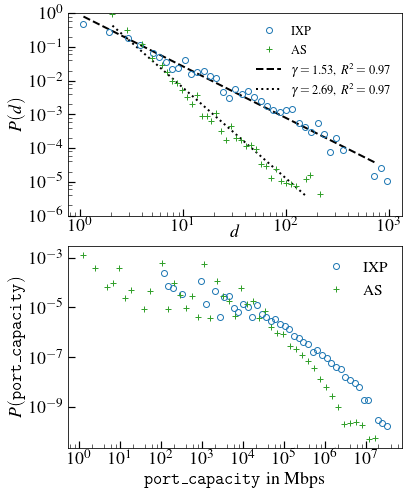

In [13]:
def myExpFunc(x, a, b):
    return a * np.power(x, b)
def myLinFunc(x, a, b):
    return a + x*b

def logfit(xdata, ydata):
    """
    Linear fit of power law distribution
    Return fitted ydata, [a,b], R2 score
    """
    xlog = np.log10(xdata)
    ylog = np.log10(ydata)
    
    popt, pcov = curve_fit(myLinFunc, xlog, ylog)
    
    ss_res = np.sum((ylog - myLinFunc(xlog, *popt))**2) #sum of square residuals
    ss_tot = np.sum((ylog - np.mean(ylog))**2) #total sum of square
    
    yfit = np.power(10, myLinFunc(xlog, *popt))
    r_squared = 1 - (ss_res/ss_tot)
    
    return yfit, popt, r_squared

def filter_zeros(xdata, ydata):
    """Remove ydata[:]==0 and the associated points in xdata"""
    xfilt, yfilt = [], []
    for i in range(np.size(ydata)):
        if ydata[i] > 0:
            xfilt.append(xdata[i])
            yfilt.append(ydata[i])
    return np.asarray(xfilt), np.asarray(yfilt)

def plot_distribution(data, ax, nPoints=50, **kwargs):
    """
    Useful to represent weights distribution
    kwargs goes to plot 
    """
    peaks, bins = np.histogram(data, bins=np.logspace(np.log10(np.min(data)), np.log10(np.max(data)),50), density=True)
    
    xaxis, yaxis = filter_zeros(bins[:-1]-np.asarray([0.5*(bins[i] - bins[i+1]) for i in range(np.size(bins)-1)]), peaks)
    ax.plot(xaxis, yaxis, **kwargs)
    return xaxis, yaxis



nodesAS = nodes_jan.loc[nodes_jan["type"]=="AS"]
nodesIXP = nodes_jan.loc[nodes_jan["type"]=="IXP"]

IXPstyle = {"color":color[1], "linewidth":0, "markersize":6, "zorder":10, "marker":"o", "fillstyle":"none", "label":"IXP"}
ASstyle = {"color":color[3], "linewidth":0, "markersize":6, "zorder":11, "marker":"+", "label":"AS"}

fig = plt.figure(figsize=(6,8))
ax1, ax2 = [plt.subplot(2,1,i+1) for i in range(2)]

xaxis, yaxis = plot_distribution(nodesIXP["OutDegree"].values, ax=ax1, **IXPstyle)
xaxis2, yaxis2 = plot_distribution(nodesAS["OutDegree"].values, ax=ax1,**ASstyle)

ydata, popt, r_squared = logfit(xaxis, yaxis)
ax1.loglog(xaxis[:-2], ydata[:-2], zorder=2, marker = "", 
           linewidth=2, linestyle="dashed", color="black", 
           label=r"$\gamma = %.2f$, $R^2=%.2f$"%(abs(popt[1]), r_squared))

ydata, popt, r_squared = logfit(xaxis2, yaxis2)
ax1.loglog(xaxis2[1:-2], ydata[1:-2], zorder=2, marker = "", 
           linewidth=2, linestyle="dotted", color="black", 
           label=r"$\gamma = %.2f$, $R^2=%.2f$"%(abs(popt[1]), r_squared))

ax1.legend(loc="upper right", frameon=False, fontsize=12.5)
ax1.set_xlabel(r"$d$", labelpad=-10)
ax1.set_ylabel(r"$P(d)$")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_ylim(1e-6,1)

plot_distribution(nodesIXP["port_capacity"].values, ax=ax2, **IXPstyle)
plot_distribution(nodesAS["port_capacity"].values, ax=ax2,**ASstyle)


ax2.legend(loc="upper right", frameon=False)
ax2.set_xlabel(r"{\tt port\_capacity} in Mbps")
ax2.set_ylabel(r"$P({\tt port\_capacity})$")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xticks([10**(i) for i in range(8)])

# ticks formatting
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=8) 
ax1.yaxis.set_major_locator(locmaj)

locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax1.yaxis.set_minor_locator(locmin)
ax1.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())


locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax2.xaxis.set_minor_locator(locmin)
ax2.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

plt.subplots_adjust(wspace=0, hspace=0.15)
plt.savefig("powerlaw.pdf", bbox_inches="tight")

## Figure 4 port_capacity vs degree

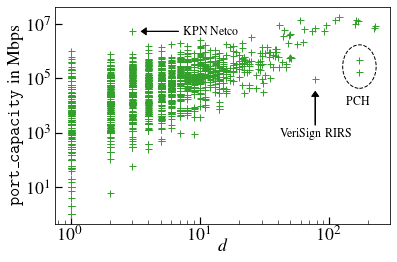

In [14]:
from matplotlib import patches

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.loglog(nodesAS["OutDegree"], nodesAS["port_capacity"], linewidth=0, marker="+", fillstyle="none", color= color[3])

ellipse = patches.Ellipse((0.908, 0.725), 0.1, 0.2, transform=ax.transAxes,fill=False, edgecolor="black", linestyle="--", linewidth=1)
ax.add_artist(ellipse)

ax.annotate('PCH', xycoords=ax.transAxes, xy=(0.868, 0.55), xytext=(0.868, 0.55), fontsize=12)

ax.annotate('VeriSign RIRS', xycoords=ax.transAxes, xy=(0.776, 0.62), xytext=(0.776, 0.4),
            arrowprops=dict(facecolor='black', shrink=0.05, mutation_scale=0.5,
                           width = 0.1, headwidth=7, headlength=5),
           ha="center", fontsize=12)

ax.annotate('KPN Netco', xycoords=ax.transAxes, xy=(0.25, 0.887), xytext=(0.38, 0.887),
            arrowprops=dict(facecolor='black', shrink=0.05, mutation_scale=0.5,
                           width = 0.1, headwidth=7, headlength=5),
           ha="left", va="center",fontsize=12)

# ax.set_xlabel(r"$d$")
ax.set_ylabel(r"${\tt port\_capacity}$ in Mbps")
# ax.set_yticks([1,1e3,1e6])
# ax.set_yticklabels(["Mbps", "Gbps", "Tbps"])
ax.set_xlabel(r"$d$", labelpad=-5)
plt.savefig("pc_vs_d.pdf", bbox_inches="tight")

In [15]:
nodes_jan.loc[[1136,42,3856,26415], ["port_capacity", "InDegree"]].astype(int).set_index([["KPN-Netco","PCH1","PCH2","VeriSign RIRS"]])

port_capacity  InDegree
KPN-Netco            5600000         3
PCH1                  479607       171
PCH2                  176714       170
VeriSign RIRS          96000        78

In [16]:
nodes_jan.loc[nodes_jan["type"] == "AS"][["port_capacity", "InDegree"]].rank(method="first", ascending=False).loc[[1136,42,3856,26415]].astype(int).set_index([["KPN-Netco","PCH1","PCH2","VeriSign RIRS"]]).rename(columns={"port_capacity" : "port_capacity rank", "InDegree" : "InDegree rank"})

port_capacity rank  InDegree rank
KPN-Netco                      15           1876
PCH1                          136              3
PCH2                          469              4
VeriSign RIRS                 739             13

January graph metrics

In [17]:
#inbound metrics
nodes["PageRank"] = nodes["asn"].map(pygomax.pagerank_cpp(pygomax.GoogleMatrix(data=DiGraph, weighted=True), maxiter=150))
nodes["InDegree"] = nodes["asn"].map(dict(DiGraph.in_degree()))
nodes["InWeight"] = nodes["asn"].map(dict(DiGraph.in_degree(weight="weight")))
nodes["PageRankNoPond"] = nodes["asn"].map(pygomax.pagerank_cpp(pygomax.GoogleMatrix(data=DiGraph, weighted=False), maxiter=150))


#outbound metrics
nodes["CheiRank"] = nodes["asn"].map(pygomax.pagerank_cpp(pygomax.GoogleMatrix(data=DiGraph.reverse(), weighted=True), maxiter=150))
nodes["OutDegree"] = nodes["asn"].map(dict(DiGraph.out_degree()))
nodes["OutWeight"] = nodes["asn"].map(dict(DiGraph.out_degree(weight="weight")))
nodes["CheiRankNoPond"] = nodes["asn"].map(pygomax.pagerank_cpp(pygomax.GoogleMatrix(data=DiGraph.reverse(), weighted=False), maxiter=150))

## Table 5 ranks for both snapshots

In [18]:
# ktop = 20
# tops = pd.DataFrame(data = {
#     "PageRank 2020-01-01": nodes_jan.sort_values(by="PageRank", ascending=False).head(ktop)["name"].values,
#     "PageRank 2020-06-01": nodes.sort_values(by="PageRank", ascending=False).head(ktop)["name"].values,

#     "Reverse PageRank 2020-01-01": nodes_jan.sort_values(by="CheiRank", ascending=False).head(ktop)["name"].values,
#     "Reverse PageRank 2020-06-01": nodes.sort_values(by="CheiRank", ascending=False).head(ktop)["name"].values

# }, index = range(1,ktop+1))
# tops

In [19]:
# tops.to_csv("Table5.csv")

In [20]:
# nodes.loc[nodes["type"]=="AS"].sort_values(by="OutDegree", ascending=False).head(20)

## Figure 2: IXP traffic balance

In [21]:
Imbalance = (nodes_jan.loc[nodes_jan.type=="IXP"]["OutWeight"] - nodes_jan.loc[nodes_jan.type=="IXP"]["InWeight"])/(nodes_jan.loc[nodes_jan.type=="IXP"]["InWeight"] + nodes_jan.loc[nodes_jan.type=="IXP"]["OutWeight"])
Imbalance.describe()

count    686.000000
mean       0.004571
std        0.256154
min       -0.904762
25%       -0.115067
50%        0.000000
75%        0.103147
max        0.904762
dtype: float64

In [22]:
stats_df = pd.DataFrame(Imbalance, columns=["value"]) \
.groupby('value') \
['value'] \
.agg('count') \
.pipe(pd.DataFrame) \
.rename(columns = {'value': 'frequency'})

# PDF
stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])

# CDF
stats_df['cdf'] = stats_df['pdf'].cumsum()
stats_df = stats_df.reset_index()
stats_df

value  frequency       pdf       cdf
0   -0.904762          2  0.002915  0.002915
1   -0.902954          1  0.001458  0.004373
2   -0.846154          1  0.001458  0.005831
3   -0.739130          1  0.001458  0.007289
4   -0.645437          1  0.001458  0.008746
..        ...        ...       ...       ...
537  0.753333          1  0.001458  0.991254
538  0.761827          1  0.001458  0.992711
539  0.787709          1  0.001458  0.994169
540  0.814433          1  0.001458  0.995627
541  0.904762          3  0.004373  1.000000

[542 rows x 4 columns]

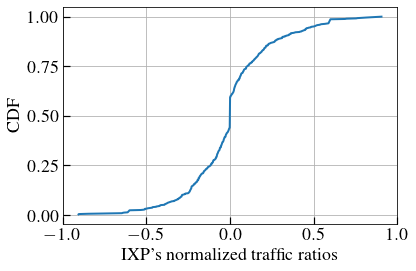

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)
stats_df.plot(x = 'value', y = ['cdf'], grid = True, ax=ax, legend=False)
ax.set_xticks([-1,-0.5,0.0,0.5,1])
ax.set_yticks([0.0,0.25,0.5,0.75,1])
ax.set_xlabel("IXP's normalized traffic ratios")
ax.set_ylabel("CDF")
fig.savefig("ixps_ratio_cdf.pdf", bbox_inches="tight")

# Clustering for january

## What are the geographical data available ?

For IXPs, the country is given in peeringDB  
For ASes, we have a coarse information on the regional presence, with the possible values

In [24]:
list(net_jan.info_scope.unique())

['Global',
 'Europe',
 'North America',
 'Regional',
 '',
 'Asia Pacific',
 'Not Disclosed',
 'Australia',
 'South America',
 'Africa',
 'Middle East']

In [25]:
net_jan.info_scope.value_counts(normalize=True)

Regional         0.318205
Europe           0.174007
Not Disclosed    0.125529
Global           0.113770
Asia Pacific     0.102218
South America    0.061578
North America    0.057246
Africa           0.021248
Australia        0.016194
                 0.007839
Middle East      0.002166
Name: info_scope, dtype: float64

In [26]:
TableRegion = net_jan.replace("","Not Disclosed")["info_scope"].value_counts(normalize="True")
display(TableRegion)

Regional         0.318205
Europe           0.174007
Not Disclosed    0.133368
Global           0.113770
Asia Pacific     0.102218
South America    0.061578
North America    0.057246
Africa           0.021248
Australia        0.016194
Middle East      0.002166
Name: info_scope, dtype: float64

We see that a large proportion of ASes are registered as `Not Disclosed`, `Regional`, or left empty summing up to 45% This does not give us much information that we will enhanced with two clustering methods

## AS Clustering based on IXPs country

For each AS we look at the continent/country it is the most present at with IXP membership.  
With continents :

### Country assignement

In [27]:
def get_continent_distrib(AS):
    continents = {}
    for netix in AS.netixlan_set:
        
        if len(ix_jan.loc[ix_jan.id == netix['ix_id']].region_continent.values) == 1:
            continent = ix_jan.loc[ix_jan.id == netix['ix_id']].region_continent.values[0]
        else:
            continent = "Empty"
            print("no continent for IXP", netix['name'])
            
        if continent not in continents:
            continents[continent] = 1
        else:
            continents[continent] += 1
            
    return continents

def get_continent_prop(AS):
    continents = AS.continent_distrib
    maximum = 0
    summ = 0
    for key in continents:
        summ += continents[key]
        if continents[key] > maximum:
            maximum = continents[key]
            continent = key
    return pd.Series([continent, maximum/summ], index=['continent_main', 'continent_prop'])

net_jan["continent_distrib"] = net_jan.apply(get_continent_distrib, axis=1)
temp = net_jan.apply(get_continent_prop, axis=1, result_type="expand")
net_jan = net_jan.join(temp)
print("Proportion of AS present in multiple continents")
print(net_jan.continent_distrib.apply(lambda x: len(x)).value_counts(normalize=True))

Proportion of AS present in multiple continents
1    0.921093
2    0.045487
3    0.020939
4    0.006189
5    0.002888
7    0.001960
6    0.001444
Name: continent_distrib, dtype: float64


With countries:

In [28]:
def get_country_distrib(AS):
    countries = {}
    for netix in AS.netixlan_set:
        
        if len(ix_jan.loc[ix_jan.id == netix['ix_id']].country.values) == 1:
            country = ix_jan.loc[ix_jan.id == netix['ix_id']].country.values[0]
        else:
            country = "Empty"
            print("no continent for IXP", netix['name'])
            
        if country not in countries:
            countries[country] = 1
        else:
            countries[country] += 1
    return countries

def get_country_prop(AS):
    countries = AS.country_distrib
    maximum = 0
    summ = 0
    #get maximum country occurences
    for key in countries:
        summ += countries[key]
        if countries[key] > maximum:
            maximum = countries[key]
            country = key
    #check if several countries are equal at max occurence
    Ntie = 0
    for key in countries:
        if countries[key] == maximum:
            Ntie += 1
            
    return pd.Series([country, maximum/summ, Ntie], index=['country_main', 'country_prop', 'country_tie'])

net_jan["country_distrib"] = net_jan.apply(get_country_distrib, axis=1)

temp = net_jan.apply(get_country_prop, axis=1, result_type="expand")
net_jan = net_jan.join(temp)

Sometimes an AS may be equally predominant in different countries. How often does this happens ?

In [29]:
print("Proportion of tied countries", 100*len(net_jan.loc[net_jan["country_tie"]>1]) / len(net) ,"%")

Proportion of tied countries 5.1232102853803445 %


In [30]:
net_jan.columns

Index(['website', 'looking_glass', 'route_server', 'info_ratio', 'id',
       'policy_ratio', 'info_unicast', 'policy_general', 'status', 'updated',
       'info_traffic', 'info_multicast', 'policy_locations', 'name',
       'info_scope', 'notes', 'created', 'org_id', 'policy_url', 'info_ipv6',
       'info_type', 'info_prefixes6', 'aka', 'info_prefixes4',
       'policy_contracts', 'irr_as_set', 'netixlan_set', 'ix_count',
       'port_capacity', 'asn', 'continent_distrib', 'continent_main',
       'continent_prop', 'country_distrib', 'country_main', 'country_prop',
       'country_tie'],
      dtype='object')

We name the AS tied and forward the results to nodes_jan for vizualization

In [31]:
net_jan.loc[net_jan["country_tie"]>1, "country_main"] = "Tied"

In [32]:
nodes_jan["country"] = nodes_jan.index.map({**ix_jan.set_index("asn")["country"], **net_jan.set_index("asn")["country_main"]})

### Table 4 : Validation with Caida as2org data

**Loading Caida as2org dataset**

In [33]:
import io

with open("20200101.as-org2info.txt") as f:
    contents1, sentinel, contents2 = f.read().partition("# format:aut|changed|aut_name|org_id|opaque_id|source")
    
org_caida = pd.read_csv(io.StringIO(contents1), names=["org_id","changed","name", "country", "source"], comment='#' ,sep='|')
AS_caida = pd.read_csv(io.StringIO(contents2), names=["ASN","changed","name", "org_id", "opaque_id", "source"], comment='#' ,sep='|').set_index("ASN")

AS_caida["country"] = AS_caida["org_id"].map(org_caida.set_index("org_id")["country"])

In [34]:
org_caida

org_id     changed                          name country source
0          01CO-ARIN  20170128.0                        O1.com      US   ARIN
1          111S-ARIN  20191028.0  One Eleven Internet Services      US   ARIN
2      1800CO-2-ARIN  20171130.0          1-800 Contacts, Inc.      US   ARIN
3        1800FL-ARIN  20150409.0       1-800-Flowers.com, Inc.      US   ARIN
4         1800H-ARIN  20160520.0           1-800-HOSTING, Inc.      US   ARIN
...              ...         ...                           ...     ...    ...
77004     ZYEDG-ARIN  20091111.0                    ZyEdge LLC      US   ARIN
77005   ZYNGA-5-ARIN  20111003.0                   Zynga Corp.      US   ARIN
77006     ZYNGA-ARIN  20150819.0                    Zynga Inc.      US   ARIN
77007   ZYWAV-1-ARIN  20191122.0                    ZYWAVE INC      US   ARIN
77008     ZYY-1-ARIN  20191209.0               ZYY Corporation      US   ARIN

[77009 rows x 5 columns]

In [35]:
AS_caida

changed              name          org_id  \
ASN                                                    
1       20180220.0            LVLT-1    LPL-141-ARIN   
2       20120621.0          UDEL-DCN  UNIVER-19-ARIN   
3       20100927.0      MIT-GATEWAYS      MIT-2-ARIN   
4       20120313.0            ISI-AS     USC-32-ARIN   
5       19950808.0         SYMBOLICS  SYMBOL-16-ARIN   
...            ...               ...             ...   
398253  20191226.0            GPR-DH     DH-325-ARIN   
398254  20191226.0  PRELUDE-SERVICES    PS-1410-ARIN   
399258  20191216.0          AS-JL-04     JL-358-ARIN   
399259  20191002.0          AS399259      ZYY-1-ARIN   
399260  20190628.0           C1CX-PA  CONVE-139-ARIN   

                                    opaque_id source country  
ASN                                                           
1       e5e3b9c13678dfc483fb1f819d70883c_ARIN   ARIN      US  
2       c3a16289a7ed6fb75fec2e256e5b5101_ARIN   ARIN      US  
3       d98c567cda2db06e693f2b574eafe848_ARIN   ARIN      US  
4       8c3f2df306a67e97a7abb5a2a0335865_ARIN   ARIN      US  
5       17758c838b246924a54466f28f2b45ef_ARIN   ARIN      US  
...                                       ...    ...     ...  
398253  47c0dc50eaec7ff7a13e781c75e2a094_ARIN   ARIN      PR  
398254  340a871bd1a9034085c84298a0bd8fba_ARIN   ARIN      US  
399258  8e928224ec2b17267c2d5abb0bbf4ade_ARIN   ARIN      US  
399259  7d29dd9ad5206e32f658166c7136466c_ARIN   ARIN      US  
399260  9caff45743f02115639aa89076bbff45_ARIN   ARIN      US  

[94120 rows x 6 columns]

In [36]:
print(len([asn for asn in net_jan.index if asn in AS_caida.index]), len(net_jan))

9644 9695


In [37]:
# display(countries_pdb)
from sklearn.metrics import classification_report

**Table 4: ASes country classification metrics** 

In [38]:
countries_list = ["US", "CA", "BR", "DE", "NL", "GB", "FR", "IT", "ES", "RU", "PL", "CN", "IN", "JP"]

In [39]:
countries_caida = AS_caida.loc[AS_caida.index.isin(nodes_jan.index)]["country"].sort_index().astype("str")
countries_pdb = nodes_jan.loc[nodes_jan.index.isin(countries_caida.index)]["country"].sort_index().astype("str")
assert(len(countries_caida) == len(countries_pdb))
countries_unique = list(set(countries_caida.unique()).union(set(countries_pdb.unique())))

report = pd.DataFrame(classification_report(countries_caida.values, countries_pdb.values, labels = countries_unique, output_dict=True)).T
report["support"] = report["support"].astype(int)

formats = {'precision': '{:.2f}', 'recall': '{:.2f}', 'f1-score': '{:.2f}', 'support': '{:d}'}

for col, f in formats.items():
    report[col] = report[col].map(lambda x: f.format(x))

# report.loc[["US", "BR", "FR", "DE", "GB", "IT", "ES", "RU", "PL", "IN", "HK", "SG"], :]
report.loc[countries_list, :].T

/home/justin/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/justin/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/justin/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/justin/anaconda3/lib/python3.7/si

US    CA    BR    DE    NL    GB    FR    IT    ES    RU    PL  \
precision  0.88  0.93  0.99  0.75  0.73  0.90  0.92  0.94  0.96  0.90  0.98   
recall     0.89  0.80  0.99  0.86  0.81  0.76  0.86  0.91  0.90  0.91  0.96   
f1-score   0.88  0.86  0.99  0.80  0.77  0.82  0.89  0.93  0.93  0.90  0.97   
support    1360   297  1302   484   288   440   308   228   114   290   421   

             CN    IN    JP  
precision  0.79  0.99  0.92  
recall     0.48  0.98  0.96  
f1-score   0.60  0.99  0.94  
support      56   438   227

In [40]:
report.loc[countries_list, :].T.to_csv('caida_as2org2country.csv')

In [41]:
plt.style.use('default')
plt.style.use(['science','ieee'])

Text(0, 0.5, '\\#AS')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


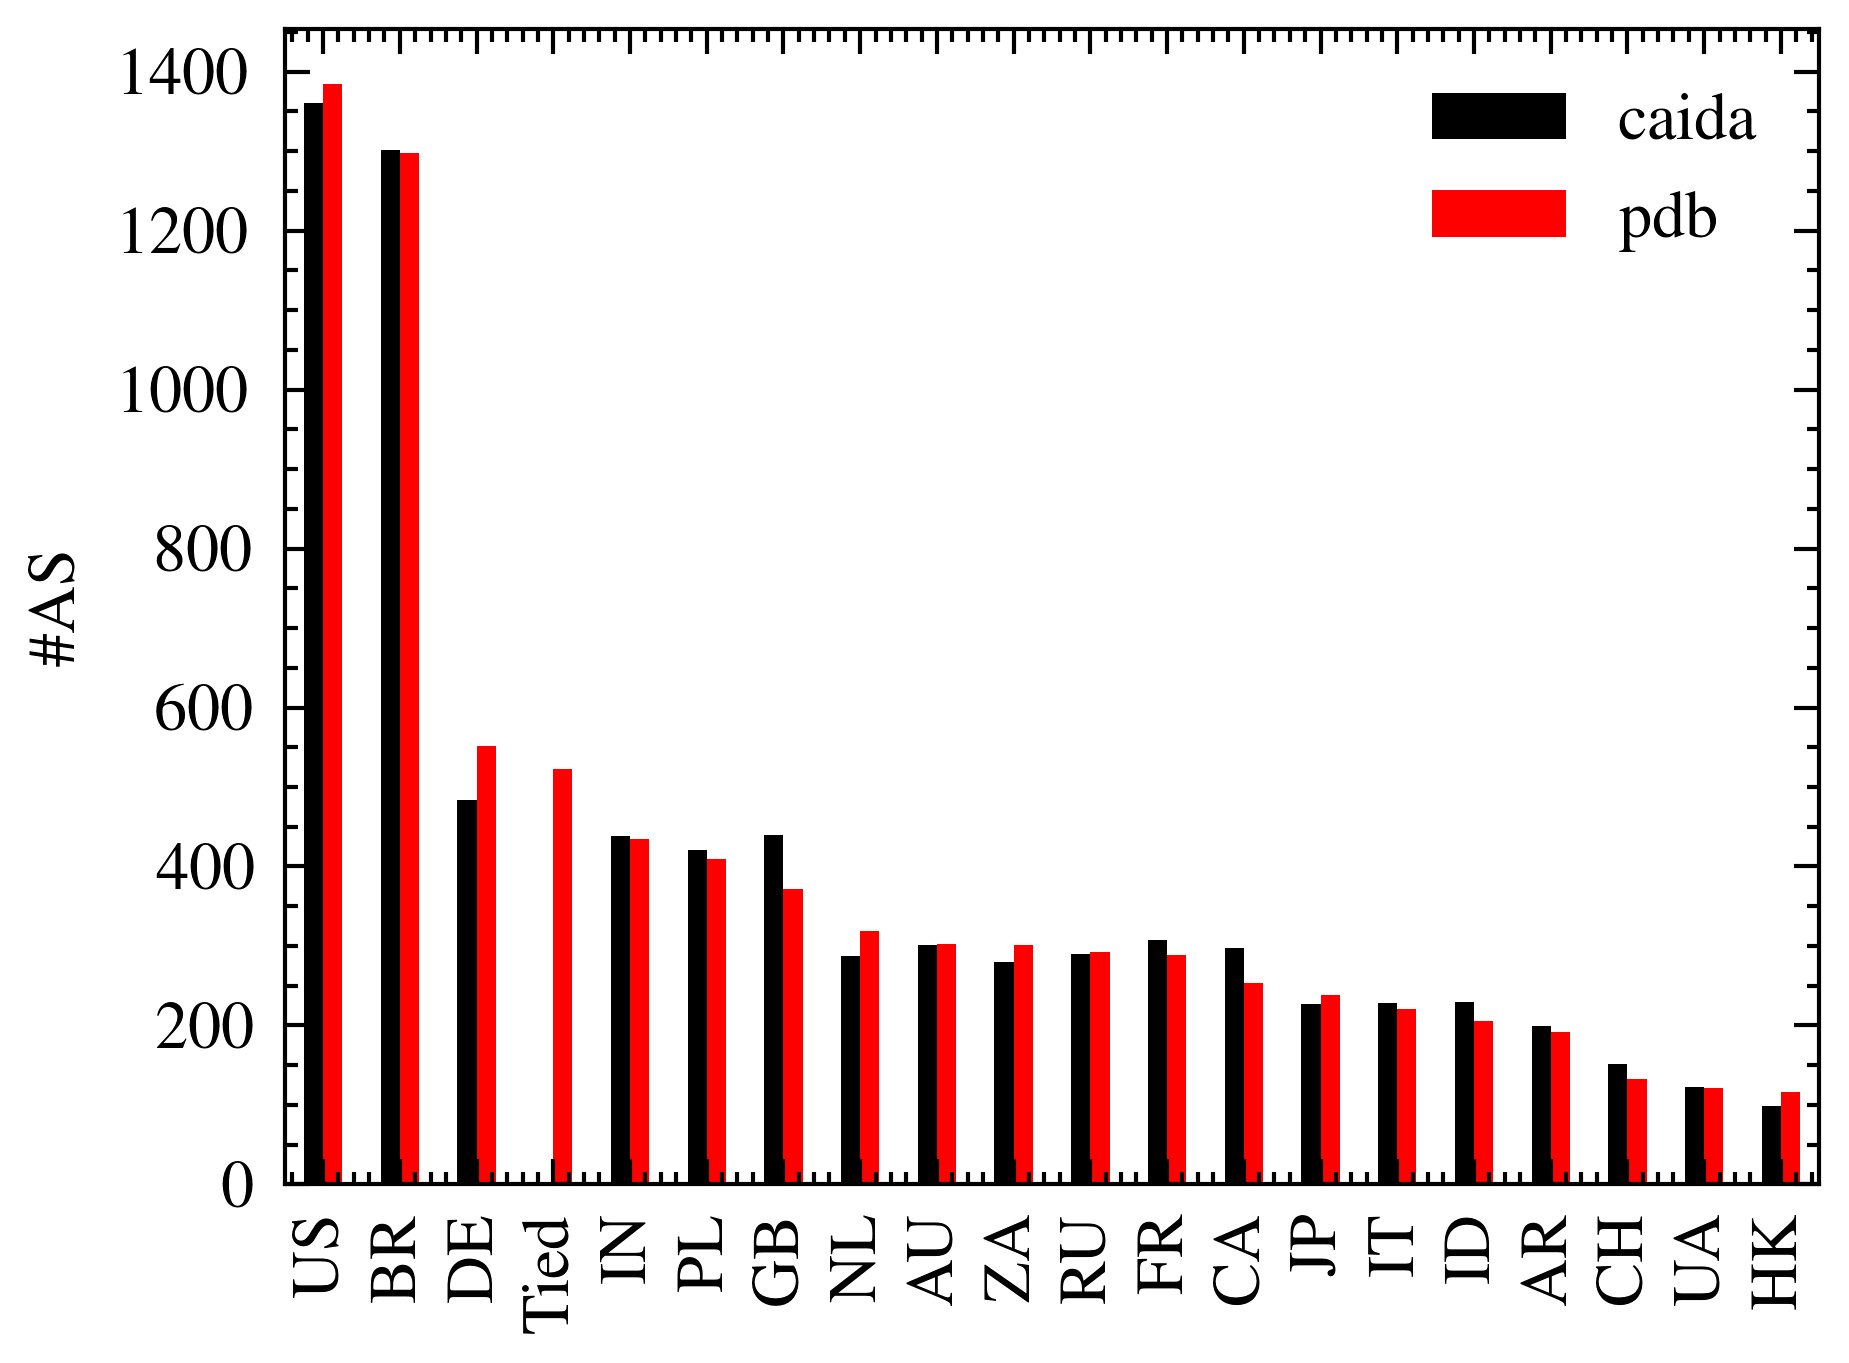

In [42]:
temp = pd.DataFrame(data={"caida": countries_caida, "pdb": countries_pdb}, index=countries_caida.index)
fig, ax = plt.subplots()
temp.apply(pd.Series.value_counts).sort_values(by="pdb", ascending=False).head(20).plot.bar(ax=ax)
ax.set_ylabel("\#AS")

## Clustering for AS and IXP based on bilouvain algorithm

Bi-louvain algorithm we use contains random numbers. Unfortunately the [implementation](https://github.com/THUfl12/bipartite-louvain) we use does not allow to provide a seed. Typically the number of cluster vary from 25 to 35, and the consitution is roughly similar

We show how to obtain one clustering, and then load a previously computed one presented in the paper.

Bilouvain is applied on undirected graphs. We need to cast our directed graph using a custom function. In peeringDB capacity directed graph, if an edge $i \rightarrow j$ exists, then $j \rightarrow i$ exist too. We make a custom function `undirect_aggweight` that create a new undirected edge combining the two directed edges weights. Using `networkx` casting `nx.Graph(nx.Digraph)` would not have been acceptable since it only selects randomly one of the two directed edges to keep as undirected.

In [43]:
# BETA_H = 0.95
# BETA_M = 0.75

# date = "2020_01_01"

# edgelist = open("caida_pdbs/processed/graph/"+format(BETA_H, '.4f')+"_"+format(BETA_M, '.4f')+"_"+prefix+date+".txt", "r")
# DiGraph = nx.parse_edgelist(edgelist, nodetype = int, data=(('weight',float),), create_using = nx.DiGraph, delimiter=",")

In [44]:
def undirect_aggweight(DiGraph):
    """works only if all edges are doubled
    """
    links = {}
    for u, v, d in DiGraph.edges(data=True):
        if (str(u)+"_"+str(v) not in links) and (str(v)+"_"+str(u) not in links):
            links[str(u)+"_"+str(v)] = d["weight"]
        elif (str(u)+"_"+str(v) not in links) and (str(v)+"_"+str(u) in links):
            links[str(v)+"_"+str(u)] += d["weight"]
        
    Graph = nx.Graph()
    for link in links:
        Graph.add_edge(int(link.split('_')[0]), int(link.split('_')[1]), weight=links[link])
    return Graph

We will only work with the Graph main connected components since it accounts for 99% of total nodes and roughly divide by 2 the number of found clusters. The isolated nodes will be considered to be in the same cluster `-1`

In [45]:
components_size = [len(c) for c in sorted(nx.connected_components(nx.Graph(DiGraph_jan)), key=len, reverse=True)]
print("Percentage of nodes in the graph main connected component", 100*components_size[0]/DiGraph_jan.number_of_nodes())
Main_comp = DiGraph_jan.subgraph(max(nx.connected_components(nx.Graph(DiGraph_jan)), key=len))

Percentage of nodes in the graph main connected component 99.19082939986514


Using bilouvain implentation found in https://github.com/THUfl12/bipartite-louvain  
Make sure to rename cloned `bipartite-louvain` to `bipartite_louvain` to conform to Python synthax

We take a look at a large number of louvain partitions:

In [46]:
from bipartite_louvain.src.new_bilouvain import new_bilouvain
from bipartite_louvain.src.bigraph import BiGraph

from IPython.display import display

nodes_jan["asn"] = nodes_jan.index

def bilouvain(Graph, nodes):
    ## we need to store the bipartite node set in the attribute color, red for AS, blue for IXP
    colors = {}
    def get_color(node):
        if node["type"] == "AS":
            colors[node.asn] = {"color": "red"}
        elif node["type"] == "IXP":
            colors[node.asn] = {"color": "blue"}

    nodes_jan.apply(get_color, axis=1)
    
    nx.set_node_attributes(Graph, colors)
    
    i=0
    for node in Graph.nodes(data=True):
        if "color" in node[1]:
            i+=1
    
    bigraph = BiGraph()
    bigraph.build_init_bigraph(Graph)

    epochs = 5
    bimodularity_list, partitions_size_list = [0]*epochs, [0]*epochs
    max_bimod = 0.0
    for i in range(epochs):
        bimodularity, partition = new_bilouvain(bigraph, randomize=True)
        
        if bimodularity > max_bimod:
            max_bimod = bimodularity
            best_partition = partition
            
        bimodularity_list[i] = bimodularity
        partitions_size_list[i] = len(set(partition.values()))
        
        nodes_jan["louvain"] = nodes_jan["asn"].map(partition)
        nodes_jan.loc[nodes_jan["louvain"].isna(),"louvain"] = -1 #We attribute the nodes outside of the main component
        

        
        Ncols = 12
        columns = nodes_jan.loc[nodes_jan["type"]=="IXP"].groupby("louvain").agg({"port_capacity":np.sum})["port_capacity"].sort_values(ascending=False).index[:Ncols]

        Table_Louvain = pd.DataFrame(columns=columns,
                                     index = ["IXPs country distribution", "#Different IXP countries",  "Port capacity (%)", "Number of IXP (%)"])

        port_capa = nodes_jan.loc[nodes_jan["type"]=="IXP"].groupby("louvain").agg({"port_capacity":np.sum})["port_capacity"].sort_values(ascending=False)
        port_capa /= port_capa.sum()

        size = nodes_jan.loc[nodes_jan["type"]=="IXP"].groupby("louvain").size().sort_values(ascending=False)/len(ix_jan)

        for col in columns:

            ## Get distribution of countries
            top_distrib = 5
            distribution = nodes_jan.loc[nodes_jan["type"]=="IXP"].groupby("louvain")['country'].agg("value_counts")[int(col)][:top_distrib]
            top_distrib = len(distribution)

            formatted_distribution = ""
            for j in range(top_distrib):
                if j == 0:
                    formatted_distribution += str(distribution.index[j]) + ": " + str(distribution.values[j])
                else:
                    formatted_distribution += " | " + str(distribution.index[j]) + ": " + str(distribution.values[j])


            Table_Louvain.loc["IXPs country distribution", col] = formatted_distribution

            Table_Louvain.loc["#Different IXP countries", col] = len(nodes_jan.loc[nodes_jan["type"]=="IXP"].groupby("louvain")['country'].agg("value_counts")[int(col)])

            Table_Louvain.loc["Port capacity (%)", col] = format(port_capa.loc[col]*100, ".1f")

            Table_Louvain.loc["Number of IXP (%)", col] = format(size.loc[col]*100, ".1f")
            
        Table_Louvain.to_csv("louvains/epoch"+str(i)+".csv")
            
        display(Table_Louvain)
            
            
          
    print("Number of cluster mean of", np.mean(partitions_size_list), "+-", np.std(partitions_size_list))
    print("Bimodularity mean of", np.mean(bimodularity_list), "+-", np.std(bimodularity_list))
    
    return max_bimod, best_partition

bimod, partition = bilouvain(undirect_aggweight(Main_comp), nodes_jan.loc[nodes_jan.asn.isin(Main_comp.nodes)])
print("bimodularity for best partition = ", bimod)
print("number of partition = ", len(set(partition.values())))

nodes_jan["louvain"] = nodes_jan["asn"].map(partition)
nodes_jan.loc[nodes_jan["louvain"].isna(),"louvain"] = -1 #We attribute the nodes outside of the main component to a cluster
nodes_jan["louvain"] = nodes_jan["louvain"].astype(np.int)

louvain                                                       0.0   \
IXPs country distribution  US: 79 | CA: 10 | GU: 2 | BE: 1 | CO: 1   
#Different IXP countries                                        12   
Port capacity (%)                                             19.0   
Number of IXP (%)                                             14.6   

louvain                                                      1.0   \
IXPs country distribution  DE: 18 | AT: 4 | CH: 4 | ID: 2 | AE: 1   
#Different IXP countries                                       23   
Port capacity (%)                                            11.6   
Number of IXP (%)                                             6.9   

louvain                                                       3.0   \
IXPs country distribution  FR: 14 | GB: 11 | IE: 5 | US: 3 | TW: 2   
#Different IXP countries                                        16   
Port capacity (%)                                             10.1   
Number of IXP (%)                                              6.7   

louvain                                                     4.0   \
IXPs country distribution  NL: 8 | BE: 1 | DK: 1 | IS: 1 | LU: 1   
#Different IXP countries                                       5   
Port capacity (%)                                            9.9   
Number of IXP (%)                                            1.7   

louvain                                                      7.0   \
IXPs country distribution  BR: 34 | RO: 4 | KE: 2 | AO: 1 | CO: 1   
#Different IXP countries                                       13   
Port capacity (%)                                             8.7   
Number of IXP (%)                                             7.3   

louvain                                      8.0   \
IXPs country distribution  JP: 11 | CW: 1 | EE: 1   
#Different IXP countries                        3   
Port capacity (%)                             7.2   
Number of IXP (%)                             1.9   

louvain                                                      5.0   \
IXPs country distribution  ID: 14 | SG: 5 | HK: 4 | PH: 4 | TH: 3   
#Different IXP countries                                       14   
Port capacity (%)                                             7.0   
Number of IXP (%)                                             6.4   

louvain                                                       11.0  \
IXPs country distribution  RU: 30 | UA: 11 | LT: 4 | KZ: 3 | KG: 2   
#Different IXP countries                                        11   
Port capacity (%)                                              5.1   
Number of IXP (%)                                              8.5   

louvain                                                      2.0   \
IXPs country distribution  SE: 10 | NO: 7 | FI: 4 | US: 3 | DK: 2   
#Different IXP countries                                        9   
Port capacity (%)                                             3.7   
Number of IXP (%)                                             4.5   

louvain                                                       10.0  \
IXPs country distribution  AR: 23 | IN: 18 | CL: 6 | US: 5 | GR: 2   
#Different IXP countries                                        16   
Port capacity (%)                                              3.4   
Number of IXP (%)                                              9.5   

louvain                                      9.0                     15.0  
IXPs country distribution  AU: 22 | NZ: 6 | PG: 1  PL: 11 | RO: 2 | PH: 1  
#Different IXP countries                        3                       3  
Port capacity (%)                             2.9                     2.3  
Number of IXP (%)                             4.2                     2.0

louvain                                                       0.0   \
IXPs country distribution  US: 73 | CA: 12 | GU: 2 | AU: 1 | CO: 1   
#Different IXP countries                                        15   
Port capacity (%)                                             18.6   
Number of IXP (%)                                             14.4   

louvain                                                      1.0   \
IXPs country distribution  DE: 22 | AT: 4 | AE: 1 | CY: 1 | HT: 1   
#Different IXP countries                                       12   
Port capacity (%)                                            11.1   
Number of IXP (%)                                             5.2   

louvain                                             3.0   \
IXPs country distribution  NL: 9 | BE: 1 | IS: 1 | LU: 1   
#Different IXP countries                               4   
Port capacity (%)                                    9.9   
Number of IXP (%)                                    1.7   

louvain                                                      6.0   \
IXPs country distribution  BR: 34 | RO: 4 | KE: 2 | AO: 1 | CO: 1   
#Different IXP countries                                       13   
Port capacity (%)                                             9.0   
Number of IXP (%)                                             7.3   

louvain                                                       2.0   \
IXPs country distribution  FR: 14 | GB: 10 | CH: 4 | US: 2 | DJ: 1   
#Different IXP countries                                        13   
Port capacity (%)                                              8.9   
Number of IXP (%)                                              5.7   

louvain                                      7.0   \
IXPs country distribution  JP: 13 | CA: 1 | HK: 1   
#Different IXP countries                        3   
Port capacity (%)                             7.3   
Number of IXP (%)                             2.2   

louvain                                                      4.0   \
IXPs country distribution  ID: 17 | PH: 4 | SG: 4 | HK: 3 | TH: 3   
#Different IXP countries                                       10   
Port capacity (%)                                             6.7   
Number of IXP (%)                                             5.7   

louvain                                                       11.0  \
IXPs country distribution  RU: 29 | UA: 11 | LT: 4 | KZ: 3 | KG: 2   
#Different IXP countries                                        11   
Port capacity (%)                                              4.9   
Number of IXP (%)                                              8.3   

louvain                                                      8.0   \
IXPs country distribution  SE: 10 | NO: 7 | FI: 4 | IE: 4 | US: 4   
#Different IXP countries                                       10   
Port capacity (%)                                             4.4   
Number of IXP (%)                                             5.4   

louvain                                                       9.0   \
IXPs country distribution  AR: 23 | IN: 18 | CL: 6 | US: 5 | AU: 2   
#Different IXP countries                                        18   
Port capacity (%)                                              3.7   
Number of IXP (%)                                             10.2   

louvain                                                      10.0  \
IXPs country distribution  AU: 21 | NZ: 6 | US: 4 | BJ: 1 | CA: 1   
#Different IXP countries                                        5   
Port capacity (%)                                             3.0   
Number of IXP (%)                                             4.8   

louvain                                              16.0  
IXPs country distribution  PL: 11 | RO: 2 | DE: 1 | PH: 1  
#Different IXP countries                                4  
Port capacity (%)                                     2.4  
Number of IXP (%)                                     2.2

louvain                                                       0.0   \
IXPs country distribution  US: 70 | CA: 12 | GU: 2 | BE: 1 | CO: 1   
#Different IXP countries                                        12   
Port capacity (%)                                             18.3   
Number of IXP (%)                                             13.6   

louvain                                                      1.0   \
IXPs country distribution  DE: 22 | AT: 4 | AE: 1 | CY: 1 | HT: 1   
#Different IXP countries                                       12   
Port capacity (%)                                            11.1   
Number of IXP (%)                                             5.2   

louvain                                                     4.0   \
IXPs country distribution  NL: 9 | US: 2 | BE: 1 | CA: 1 | LU: 1   
#Different IXP countries                                       5   
Port capacity (%)                                            9.9   
Number of IXP (%)                                            2.0   

louvain                                                      7.0   \
IXPs country distribution  BR: 34 | RO: 4 | KE: 2 | AO: 1 | CO: 1   
#Different IXP countries                                       14   
Port capacity (%)                                             9.0   
Number of IXP (%)                                             7.4   

louvain                                                      2.0     9.0   \
IXPs country distribution  FR: 14 | GB: 9 | CH: 4 | US: 2 | GN: 1  JP: 10   
#Different IXP countries                                       10       1   
Port capacity (%)                                             8.8     7.1   
Number of IXP (%)                                             5.1     1.5   

louvain                                                      5.0   \
IXPs country distribution  ID: 17 | TH: 7 | HK: 4 | PH: 4 | SG: 4   
#Different IXP countries                                       12   
Port capacity (%)                                             7.0   
Number of IXP (%)                                             6.9   

louvain                                                       11.0  \
IXPs country distribution  RU: 30 | UA: 12 | LT: 4 | KZ: 3 | KG: 2   
#Different IXP countries                                        12   
Port capacity (%)                                              5.3   
Number of IXP (%)                                              8.7   

louvain                                                      3.0   \
IXPs country distribution  SE: 11 | NO: 7 | IE: 5 | US: 5 | DK: 3   
#Different IXP countries                                       11   
Port capacity (%)                                             4.8   
Number of IXP (%)                                             5.4   

louvain                                                       8.0   \
IXPs country distribution  AR: 23 | IN: 17 | CL: 5 | US: 3 | AU: 2   
#Different IXP countries                                        16   
Port capacity (%)                                              3.1   
Number of IXP (%)                                              9.3   

louvain                              10.0                            15.0  
IXPs country distribution  AU: 21 | NZ: 6  PL: 11 | RO: 2 | DE: 1 | PH: 1  
#Different IXP countries                2                               4  
Port capacity (%)                     2.9                             2.4  
Number of IXP (%)                     3.9                             2.2

louvain                                                       0.0   \
IXPs country distribution  US: 79 | CA: 10 | GU: 2 | CN: 1 | CO: 1   
#Different IXP countries                                         8   
Port capacity (%)                                             18.9   
Number of IXP (%)                                             14.0   

louvain                                                      1.0   \
IXPs country distribution  DE: 22 | AT: 4 | CH: 4 | AE: 1 | CY: 1   
#Different IXP countries                                       15   
Port capacity (%)                                            11.7   
Number of IXP (%)                                             6.1   

louvain                                             4.0   \
IXPs country distribution  NL: 8 | BE: 1 | IS: 1 | LU: 1   
#Different IXP countries                               4   
Port capacity (%)                                    9.8   
Number of IXP (%)                                    1.6   

louvain                                                      7.0   \
IXPs country distribution  BR: 34 | RO: 4 | GB: 2 | KE: 2 | AO: 1   
#Different IXP countries                                       16   
Port capacity (%)                                             9.1   
Number of IXP (%)                                             7.9   

louvain                                                      3.0   \
IXPs country distribution  FR: 13 | GB: 9 | IE: 4 | US: 2 | DJ: 1   
#Different IXP countries                                       10   
Port capacity (%)                                             8.8   
Number of IXP (%)                                             5.0   

louvain                                              9.0   \
IXPs country distribution  JP: 11 | BE: 1 | CW: 1 | EE: 1   
#Different IXP countries                                4   
Port capacity (%)                                     7.2   
Number of IXP (%)                                     2.0   

louvain                                                      5.0   \
IXPs country distribution  ID: 15 | SG: 5 | HK: 4 | PH: 4 | JP: 2   
#Different IXP countries                                       13   
Port capacity (%)                                             6.6   
Number of IXP (%)                                             6.0   

louvain                                                       11.0  \
IXPs country distribution  RU: 30 | UA: 12 | BG: 4 | LT: 4 | KZ: 3   
#Different IXP countries                                        13   
Port capacity (%)                                              5.9   
Number of IXP (%)                                              9.5   

louvain                                                      2.0   \
IXPs country distribution  SE: 10 | NO: 7 | FI: 4 | DK: 3 | US: 3   
#Different IXP countries                                        8   
Port capacity (%)                                             3.7   
Number of IXP (%)                                             4.5   

louvain                                                      10.0  \
IXPs country distribution  AU: 24 | NZ: 6 | TW: 2 | NL: 1 | SE: 1   
#Different IXP countries                                        6   
Port capacity (%)                                             3.6   
Number of IXP (%)                                             5.1   

louvain                                                       8.0   \
IXPs country distribution  AR: 24 | IN: 18 | CL: 6 | US: 4 | GR: 2   
#Different IXP countries                                        16   
Port capacity (%)                                              3.5   
Number of IXP (%)                                              9.6   

louvain                                     13.0  
IXPs country distribution  TH: 6 | CZ: 3 | SK: 3  
#Different IXP countries                       3  
Port capacity (%)                            2.7  
Number of IXP (%)                            1.7

louvain                                                       0.0   \
IXPs country distribution  US: 75 | CA: 13 | GU: 2 | SG: 2 | BJ: 1   
#Different IXP countries                                        19   
Port capacity (%)                                             18.3   
Number of IXP (%)                                             15.6   

louvain                                                      1.0   \
IXPs country distribution  DE: 18 | CH: 4 | US: 3 | AT: 2 | AE: 1   
#Different IXP countries                                       14   
Port capacity (%)                                            11.5   
Number of IXP (%)                                             5.4   

louvain                                             2.0   \
IXPs country distribution  NL: 8 | AT: 2 | BE: 1 | US: 1   
#Different IXP countries                               4   
Port capacity (%)                                    9.7   
Number of IXP (%)                                    1.7   

louvain                                                      6.0   \
IXPs country distribution  BR: 34 | RO: 4 | GB: 2 | KE: 2 | AO: 1   
#Different IXP countries                                       16   
Port capacity (%)                                             9.1   
Number of IXP (%)                                             7.9   

louvain                                                     4.0   \
IXPs country distribution  GB: 8 | CL: 5 | IE: 4 | GR: 2 | US: 2   
#Different IXP countries                                      19   
Port capacity (%)                                            8.0   
Number of IXP (%)                                            5.1   

louvain                                                      5.0     9.0   \
IXPs country distribution  ID: 16 | TH: 7 | HK: 4 | PH: 4 | MY: 3  JP: 11   
#Different IXP countries                                       13       1   
Port capacity (%)                                             7.2     7.2   
Number of IXP (%)                                             7.0     1.6   

louvain                                                       13.0  \
IXPs country distribution  RU: 30 | UA: 11 | LT: 4 | KZ: 3 | KG: 2   
#Different IXP countries                                        12   
Port capacity (%)                                              5.2   
Number of IXP (%)                                              8.6   

louvain                                                      3.0   \
IXPs country distribution  SE: 10 | NO: 7 | FI: 4 | DK: 3 | US: 3   
#Different IXP countries                                        8   
Port capacity (%)                                             3.7   
Number of IXP (%)                                             4.5   

louvain                                                      11.0  \
IXPs country distribution  AU: 23 | NZ: 6 | TW: 2 | NL: 1 | SE: 1   
#Different IXP countries                                        6   
Port capacity (%)                                             3.6   
Number of IXP (%)                                             5.0   

louvain                                                      8.0   \
IXPs country distribution  FR: 15 | LU: 2 | BE: 1 | CI: 1 | DJ: 1   
#Different IXP countries                                        7   
Port capacity (%)                                             2.5   
Number of IXP (%)                                             3.2   

louvain                                              16.0  
IXPs country distribution  PL: 11 | RO: 2 | DE: 1 | PH: 1  
#Different IXP countries                                4  
Port capacity (%)                                     2.4  
Number of IXP (%)                                     2.2

Number of cluster mean of 34.6 +- 1.8547236990991407
Bimodularity mean of 0.5408249057252303 +- 0.001865909557090821
bimodularity for best partition =  0.5437891900747057
number of partition =  34


/home/justin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading previous Louvain

In [47]:
nodes_jan["louvain"] = pd.read_csv("caida_pdbs/processed/clustered/louvain_2020_01_01.csv").set_index("asn")["louvain"]
nodes_jan["louvain"] = nodes_jan["louvain"].astype(np.int)

/home/justin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


### size of louvain clusters IXPs and ASes, number of members

In [48]:
nodes_jan.loc[nodes_jan["type"]=="IXP"].groupby("louvain").size().sort_values(ascending=False)/len(ix)

louvain
 0     0.136240
 10    0.084469
 6     0.068120
 7     0.068120
 8     0.066757
 2     0.064033
 3     0.062670
 1     0.059946
 5     0.058583
 9     0.043597
-1     0.039510
 17    0.038147
 11    0.027248
 4     0.019074
 14    0.019074
 15    0.013624
 12    0.012262
 20    0.009537
 23    0.009537
 13    0.008174
 18    0.005450
 19    0.005450
 22    0.004087
 16    0.002725
 27    0.001362
 21    0.001362
 24    0.001362
 25    0.001362
 26    0.001362
 28    0.001362
dtype: float64

In [49]:
nodes_jan.loc[nodes_jan["type"]=="AS"].groupby("louvain").size().sort_values(ascending=False)/len(net)

louvain
 7     0.135970
 0     0.131392
 2     0.083861
 1     0.074511
 5     0.060485
 6     0.058927
 10    0.052888
 8     0.052109
 4     0.044414
 11    0.044414
 3     0.042661
 14    0.041297
 9     0.039447
 12    0.022986
 15    0.014902
 13    0.013149
 17    0.011785
-1     0.005357
 19    0.002727
 16    0.002338
 20    0.002240
 18    0.001948
 21    0.001169
 22    0.000974
 28    0.000877
 23    0.000779
 26    0.000390
 27    0.000097
 24    0.000097
 25    0.000097
dtype: float64

### size of louvain clusters IXPs and ASes, agglomerated `port_capacity`

In [50]:
port_capa = nodes_jan.loc[nodes_jan["type"]=="AS"].groupby("louvain").agg({"port_capacity":np.sum})["port_capacity"].sort_values(ascending=False)
port_capa /= port_capa.sum()
port_capa

louvain
 0     0.209012
 7     0.149268
 1     0.101477
 2     0.101036
 8     0.075587
 4     0.072343
 5     0.062201
 3     0.061792
 10    0.052516
 9     0.026930
 6     0.023983
 13    0.016845
 14    0.016462
 12    0.007927
 11    0.007788
 15    0.006276
 20    0.002295
 17    0.002006
 19    0.001755
-1     0.000628
 16    0.000572
 18    0.000474
 25    0.000191
 22    0.000187
 23    0.000139
 28    0.000125
 21    0.000117
 27    0.000038
 24    0.000021
 26    0.000008
Name: port_capacity, dtype: float64

In [51]:
port_capa = nodes_jan.loc[nodes_jan["type"]=="IXP"].groupby("louvain").agg({"port_capacity":np.sum})["port_capacity"].sort_values(ascending=False)
port_capa /= port_capa.sum()
port_capa

louvain
 0     0.185207
 1     0.116699
 2     0.100909
 4     0.100687
 7     0.086216
 8     0.082577
 5     0.070511
 10    0.058654
 3     0.049666
 9     0.033523
 6     0.028188
 14    0.023125
 13    0.022269
 12    0.012988
 11    0.011764
 15    0.008748
 20    0.002142
 17    0.001904
 19    0.001757
-1     0.000628
 16    0.000626
 18    0.000457
 25    0.000195
 22    0.000147
 28    0.000127
 23    0.000111
 21    0.000109
 27    0.000040
 24    0.000019
 26    0.000008
Name: port_capacity, dtype: float64

### Composition of bilouvain clusters

In [52]:
pd.set_option('display.max_rows', 2000)

nodes_jan = nodes_jan.set_index("asn")

AS composition

In [53]:
nodes_jan["country"] = nodes_jan.index.map({**ix_jan.set_index("asn")["country"], **net_jan.set_index("asn")["country_main"]})
# nodes_jan.loc[nodes_jan["type"]=="AS"].groupby("louvain")['country'].agg("value_counts")

### Table 8 Louvain table

In [54]:
Ncols = 12
columns = nodes_jan.loc[nodes_jan["type"]=="IXP"].groupby("louvain").agg({"port_capacity":np.sum})["port_capacity"].sort_values(ascending=False).index[:Ncols]

Table_Louvain = pd.DataFrame(columns=columns,
                             index = ["IXPs country distribution", "#Different IXP countries",  "Port capacity (%)", "Number of IXP (%)"])

port_capa = nodes_jan.loc[nodes_jan["type"]=="IXP"].groupby("louvain").agg({"port_capacity":np.sum})["port_capacity"].sort_values(ascending=False)
port_capa /= port_capa.sum()

size = nodes_jan.loc[nodes_jan["type"]=="IXP"].groupby("louvain").size().sort_values(ascending=False)/len(ix_jan)

for col in columns:
    
    ## Get distribution of countries
    top_distrib = 5
    distribution = nodes_jan.loc[nodes_jan["type"]=="IXP"].groupby("louvain")['country'].agg("value_counts")[int(col)][:top_distrib]
    top_distrib = len(distribution)
    
    formatted_distribution = ""
    for i in range(top_distrib):
        if i == 0:
            formatted_distribution += str(distribution.index[i]) + ": " + str(distribution.values[i])
        else:
            formatted_distribution += " | " + str(distribution.index[i]) + ": " + str(distribution.values[i])
      
    
    Table_Louvain.loc["IXPs country distribution", col] = formatted_distribution
    
    Table_Louvain.loc["#Different IXP countries", col] = len(nodes_jan.loc[nodes_jan["type"]=="IXP"].groupby("louvain")['country'].agg("value_counts")[int(col)])
    
    Table_Louvain.loc["Port capacity (%)", col] = format(port_capa.loc[col]*100, ".1f")
    
    Table_Louvain.loc["Number of IXP (%)", col] = format(size.loc[col]*100, ".1f")
    ##

Table_Louvain

louvain                                                         0   \
IXPs country distribution  US: 74 | CA: 12 | CO: 2 | GU: 2 | SG: 2   
#Different IXP countries                                        13   
Port capacity (%)                                             18.5   
Number of IXP (%)                                             14.6   

louvain                                                        1   \
IXPs country distribution  DE: 22 | AT: 4 | CH: 4 | US: 2 | AE: 1   
#Different IXP countries                                       16   
Port capacity (%)                                            11.7   
Number of IXP (%)                                             6.4   

louvain                                                         2   \
IXPs country distribution  FR: 15 | GB: 11 | IE: 4 | US: 3 | AU: 2   
#Different IXP countries                                        16   
Port capacity (%)                                             10.1   
Number of IXP (%)                                              6.9   

louvain                                                       4   \
IXPs country distribution  NL: 9 | BE: 1 | BJ: 1 | CA: 1 | IS: 1   
#Different IXP countries                                       6   
Port capacity (%)                                           10.1   
Number of IXP (%)                                            2.0   

louvain                                                        7   \
IXPs country distribution  BR: 34 | RO: 4 | AO: 2 | KE: 2 | US: 2   
#Different IXP countries                                       11   
Port capacity (%)                                             8.6   
Number of IXP (%)                                             7.3   

louvain                                                         8   \
IXPs country distribution  AR: 22 | JP: 13 | CL: 6 | HK: 2 | BH: 1   
#Different IXP countries                                        10   
Port capacity (%)                                              8.3   
Number of IXP (%)                                              7.1   

louvain                                                        5   \
IXPs country distribution  ID: 16 | TH: 7 | PH: 4 | HK: 3 | SG: 3   
#Different IXP countries                                       12   
Port capacity (%)                                             7.1   
Number of IXP (%)                                             6.3   

louvain                                                         10  \
IXPs country distribution  RU: 30 | UA: 12 | BG: 6 | KZ: 3 | KG: 2   
#Different IXP countries                                        12   
Port capacity (%)                                              5.9   
Number of IXP (%)                                              9.0   

louvain                                                        3   \
IXPs country distribution  SE: 10 | NO: 7 | ES: 6 | FI: 4 | DK: 3   
#Different IXP countries                                       15   
Port capacity (%)                                             5.0   
Number of IXP (%)                                             6.7   

louvain                                                9   \
IXPs country distribution  AU: 21 | NZ: 6 | US: 4 | MY: 1   
#Different IXP countries                                4   
Port capacity (%)                                     3.4   
Number of IXP (%)                                     4.7   

louvain                                                       6   \
IXPs country distribution  TZ: 5 | ZA: 5 | US: 4 | CA: 2 | CD: 2   
#Different IXP countries                                      36   
Port capacity (%)                                            2.8   
Number of IXP (%)                                            7.3   

louvain                                        14  
IXPs country distribution  PL: 11 | RO: 2 | PH: 1  
#Different IXP countries                        3  
Port capacity (%)                             2.3  
Number of IXP (%

We see that louvain cluster grouped countries with strong relationships

In [55]:
# Table_Louvain = Table_Louvain.append(pd.DataFrame(data = {1: "Germanic countries",
#                                          0: "North America",
#                                          7: "Brazil",
#                                          5: "Asia Pacific",
#                                          2: "British Isles",
#                                          10: "Japan",
#                                          13: "Former western USSR members",
#                                          3: "Scandinavian countries",
#                                          11: "Oceania Pacific",
#                                          6: "Africa",
#                                          9: "French countries?",
#                                          15 : "?"}, index=["Grouping interpretation"]))

Table_Louvain = Table_Louvain.append(pd.DataFrame(data = {0: "North America",
                                         1: "Germanic countries",
                                         2: "Western Europe",
                                         4: "Netherlands",
                                         7: "Brazil",
                                         8: "South America, East Asia",
                                         5: "South East Asia",
                                         10: "Eastern Europe",
                                         3: "Scandinavian countries",
                                         9: "Oceania Pacific",
                                         6: "Africa",
                                         14: "Eastern Europe"}, index=["Grouping interpretation"]))

Table_Louvain.reindex([Table_Louvain.index[0], Table_Louvain.index[4], Table_Louvain.index[1], Table_Louvain.index[2], Table_Louvain.index[3]])

0   \
IXPs country distribution  US: 74 | CA: 12 | CO: 2 | GU: 2 | SG: 2   
Grouping interpretation                              North America   
#Different IXP countries                                        13   
Port capacity (%)                                             18.5   
Number of IXP (%)                                             14.6   

                                                               1   \
IXPs country distribution  DE: 22 | AT: 4 | CH: 4 | US: 2 | AE: 1   
Grouping interpretation                        Germanic countries   
#Different IXP countries                                       16   
Port capacity (%)                                            11.7   
Number of IXP (%)                                             6.4   

                                                                2   \
IXPs country distribution  FR: 15 | GB: 11 | IE: 4 | US: 3 | AU: 2   
Grouping interpretation                             Western Europe   
#Different IXP countries                                        16   
Port capacity (%)                                             10.1   
Number of IXP (%)                                              6.9   

                                                              4   \
IXPs country distribution  NL: 9 | BE: 1 | BJ: 1 | CA: 1 | IS: 1   
Grouping interpretation                              Netherlands   
#Different IXP countries                                       6   
Port capacity (%)                                           10.1   
Number of IXP (%)                                            2.0   

                                                               7   \
IXPs country distribution  BR: 34 | RO: 4 | AO: 2 | KE: 2 | US: 2   
Grouping interpretation                                    Brazil   
#Different IXP countries                                       11   
Port capacity (%)                                             8.6   
Number of IXP (%)                                             7.3   

                                                                8   \
IXPs country distribution  AR: 22 | JP: 13 | CL: 6 | HK: 2 | BH: 1   
Grouping interpretation                   South America, East Asia   
#Different IXP countries                                        10   
Port capacity (%)                                              8.3   
Number of IXP (%)                                              7.1   

                                                               5   \
IXPs country distribution  ID: 16 | TH: 7 | PH: 4 | HK: 3 | SG: 3   
Grouping interpretation                           South East Asia   
#Different IXP countries                                       12   
Port capacity (%)                                             7.1   
Number of IXP (%)                                             6.3   

                                                                10  \
IXPs country distribution  RU: 30 | UA: 12 | BG: 6 | KZ: 3 | KG: 2   
Grouping interpretation                             Eastern Europe   
#Different IXP countries                                        12   
Port capacity (%)                                              5.9   
Number of IXP (%)                                              9.0   

                                                               3   \
IXPs country distribution  SE: 10 | NO: 7 | ES: 6 | FI: 4 | DK: 3   
Grouping interpretation                    Scandinavian countries   
#Different IXP countries                                       15   
Port capacity (%)                                             5.0   
Number of IXP (%)                                             6.7   

                                                       9   \
IXPs country distribution  AU: 21 | NZ: 6 | US: 4 | MY: 1   
Grouping interpretation                   Oceania Pacific   
#Different IXP countries                                4   
Port capacity (%)                                     3.4   
Number

In [56]:
Table_Louvain.reindex([Table_Louvain.index[0], Table_Louvain.index[1], Table_Louvain.index[4], Table_Louvain.index[2], Table_Louvain.index[3]]).to_csv("Table_Louvain_jan.csv")

<!-- <p align="center">
<img src="./graph_countries_annote.png" alt="Geographical" height="1500" width="1500">
</p> -->

## Eyeball networks

We retrieve the topK eyeball network by country. The goal here is to compare peeringDB regional traffic catchers to APNIC eyeball networks

In [57]:
topK = 4
countries_list = ["US", "CA", "BR", "DE", "NL", "GB", "FR", "IT", "ES", "RU", "PL", "CN", "IN", "JP"]
topCR = 20

### Loading APNIC

In [58]:
import re
from io import StringIO
import csv

def load_apnic_table(filename):

    file = open(filename, "r")
    i = 0
    table = []
    for line in file:
        temp = line.strip()
        if len(temp) > 2:
            if temp[0] == '[' and (temp[-2:] == "]," or temp[-1]==']'):
                #I need fancy csv because name fields might contain commas
                temp = next( csv.reader( StringIO(temp.lstrip('[').rstrip(',').rstrip(']')) ) )
                if i == 0:
                    data = [cell.strip().lstrip("'").rstrip("'") for cell in temp]
                else:
                    data = [int(temp[0]),
                            int(temp[1].lstrip('"AS').rstrip('"')),
                            temp[2].rstrip('"').lstrip('"'),
                            re.search('>(.*)<', temp[3]).group(1),
                            int(temp[4]),
                            float(temp[5]),
                            float(temp[6]),
                            int(temp[7])]
                i += 1
                table.append(data)
    
    file.close()
    
    df = pd.DataFrame.from_records(table[1:], columns=table[0], index='ASN')

    ##I use rank to check the dimension
    assert df.iloc[-1]["Rank"] == i-1
    
    df.index.names = ["asn"]
    
    return df.drop(columns=["Rank"])
                   
# apnic = load_apnic_table("apnic_customer_2022_02_16.html")
apnic = load_apnic_table("apnic_customer_2020_01_03.html")

apnic.sort_values(by="Users (est.)", ascending=False, inplace=True)
apnic

AS Name  CC  Users (est.)  \
asn                                                                           
4134              CHINANET-BACKBONE No.31,Jin-rong Street  CN     290768704   
55836        RELIANCEJIO-IN Reliance Jio Infocomm Limited  IN     242512729   
4837     CHINA169-BACKBONE CHINA UNICOM China169 Backbone  CN     122741209   
45609   BHARTI-MOBILITY-AS-AP Bharti Airtel Ltd. AS fo...  IN      90973817   
9808      CMNET-GD Guangdong Mobile Communication Co.Ltd.  CN      67198278   
...                                                   ...  ..           ...   
49861                                     SAHSUVAROGLU-AS  TR            92   
47123                                         MEDNAUTILUS  TR            91   
208856                                           FIBERCOM  ME            74   
51924                                  PORTOMONTENEGRO-AS  ME            69   
136942        ELITECOMPUTERDILI-AS-AP Elite Computer, LDA  TL            44   

        % of country  % of Internet   Samples  
asn                                            
4134           39.24         8.3583   9514477  
55836          51.02         6.9712  64483556  
4837           16.57         3.5283   4016314  
45609          19.14         2.6151  24189721  
9808            9.07         1.9317   2198849  
...              ...            ...       ...  
49861           0.00         0.0000       155  
47123           0.00         0.0000       153  
208856          0.02         0.0000       184  
51924           0.02         0.0000       171  
136942          0.27         0.0000       300  

[27024 rows x 6 columns]

### Table VI End-Users market share

In [59]:
FullApnicCoverage = apnic.groupby("CC").sum().loc[countries_list, "% of country"]
pDBApnicCoverage = apnic.loc[apnic.index.isin(nodes_jan.index)].groupby("CC").sum().loc[countries_list, "% of country"]

apnic.reset_index(inplace=True)

topApnic = apnic.loc[apnic.asn.isin(nodes_jan.index)].groupby("CC").head(topK).loc[apnic.CC.isin(countries_list)]
topApnic.sort_values(by=["CC", "% of country"], ascending=[True, False], inplace=True)
# topApnic.groupby("CC").sum()["% of country"]
pDBApnicCoverage4 = topApnic.groupby("CC").sum()["% of country"]


coverage = pd.DataFrame(data={"APNIC Coverage": FullApnicCoverage,
                  "pDB and Apnic Coverage": pDBApnicCoverage,
                  "top4 pDB and Apnic Coverage": pDBApnicCoverage4}, index = countries_list)
coverage.T

US     CA     BR     DE     NL     GB     FR  \
APNIC Coverage               96.61  99.49  94.57  99.36  99.67  99.39  99.67   
pDB and Apnic Coverage       32.46  86.88  53.44  92.84  86.55  87.44  57.27   
top4 pDB and Apnic Coverage  18.78  52.98  29.75  60.38  66.01  61.85  51.75   

                                IT     ES     RU     PL     CN     IN     JP  
APNIC Coverage               99.55  99.72  98.24  99.11  99.85  99.24  99.69  
pDB and Apnic Coverage       60.28  56.75  40.25  37.25  56.44   9.96  92.12  
top4 pDB and Apnic Coverage  53.95  49.52  30.09  26.64  56.07   4.34  63.54

In [60]:
pd.set_option('display.max_rows', 100)

In [61]:
def merge_list(*args):
    """Merge lists in args in single list without duplicates"""
    res = []
    for liste in args:
        for element in liste:
            if element not in res:
                res.append(element)
    return res

In [62]:
def get_rnodes(topCR, topK, countries_list, mode="ISP/ND", ASN_to_remove=[]):
    """
    Returns topCR hypergiants, and topK eyeball per country in country list.
    Some parts are complicated for two reasons:
    1) hypergiants might be discovered as eyeball, so I need to make sure that an eyeball is not already present in hypergiants.
    This is why we have a while loop
    2) If topK is set too high (for example > a number of AS in a country), then I get stuck in the while loop
    This is why I check for convergence in the number of ASes retrieved 
    """
    converged = False
    
    rnodes, rnodes_label = nodes_jan.loc[nodes_jan["type"]=="AS"].sort_values(by="CheiRank", ascending=False).head(topCR)[["asn","name"]].T.values.tolist()
    rnodes_label = list(nodes_jan.loc[rnodes, "name"])
    
    for country in countries_list:
        topK_to_search = topK ##I want to retrieve topK, sometimes I need to increase the radius to be robust
        
        
        if mode == "ISP/ND":
            mask = ((nodes_jan["type"]=="AS") &
                    (nodes_jan["country"]==country) &
                    ((nodes_jan["AStype"]=="Cable/DSL/ISP") | (nodes_jan["AStype"]=="Not Disclosed") | (nodes_jan["AStype"]=="")))
        elif mode == "ISP/NSP/ND":
            mask = ((nodes_jan["type"]=="AS") &
                    (nodes_jan["country"]==country) &
                    ((nodes_jan["AStype"]=="Cable/DSL/ISP") | (nodes_jan["AStype"]=="NSP") | (nodes_jan["AStype"]=="Not Disclosed") | (nodes_jan["AStype"]=="")))
        elif mode == "manual":
            mask = ((np.logical_not(nodes_jan.asn.isin(ASN_to_remove))) &
                    (nodes_jan["type"]=="AS") &
                    (nodes_jan["country"]==country) &
                    ((nodes_jan["AStype"]=="Cable/DSL/ISP") | (nodes_jan["AStype"]=="NSP") | (nodes_jan["AStype"]=="Not Disclosed") | (nodes_jan["AStype"]=="")))
        else:
            mask = ((np.logical_not(nodes_jan.asn.isin(ASN_to_remove))) &
                    (nodes_jan["type"]=="AS") &
                    (nodes_jan["country"]==country))

    
        merge_attempt = merge_list(rnodes, nodes_jan.loc[mask].sort_values(by="PageRank", ascending=False).head(topK_to_search)["asn"].values.tolist())
        
        while len(merge_attempt) < (len(rnodes) + topK):

            topK_to_search += 1
            new_attempt = merge_list(rnodes, nodes_jan.loc[mask].sort_values(by="PageRank", ascending=False).head(topK_to_search)["asn"].values.tolist())
            
            if len(new_attempt) == len(merge_attempt):
                converged = True
                print("Country", country, "does not have enough AS")
                break
            merge_attempt = new_attempt
                            
        rnodes = merge_list(rnodes, nodes_jan.loc[mask].sort_values(by="PageRank", ascending=False).head(topK_to_search)["asn"].values.tolist())
#         rnodes_label = merge_list(rnodes_label, nodes_jan.loc[mask].sort_values(by="PageRank", ascending=False).head(topK)["name"].values.tolist())
        rnodes_label = nodes_jan.loc[rnodes, "name"].values.tolist()
    
    if not converged:
        assert(len(rnodes) == topCR + len(countries_list)*topK)
        
    return rnodes, rnodes_label

topCR = 20
topK = 4

In [63]:
mode = "ISP/ND"


##getting rnodes
nodes_jan["asn"] = nodes_jan.index

rnodes, rnodes_label = get_rnodes(topCR, topK, countries_list, mode=mode)

##table catchers part pDB

codes = [0] * len(rnodes[topCR:])
topKs = [topK] * len(countries_list)

count = 0 
for i in range(len(countries_list)):
    for j in range(topKs[i]):
        codes[count] = countries_list[i] + str(j+1)
        count += 1
        
TableCatchers = pd.DataFrame(index = codes)
TableCatchers["name"] = nodes_jan.loc[rnodes[topCR:], "name"].values
TableCatchers["asn"] = nodes_jan.loc[rnodes[topCR:]].index
TableCatchers["country"] = [code[:2] for code in codes]
TableCatchers["rank"] = [code[-1] for code in codes]
TableCatchers["type"] = nodes_jan.loc[rnodes[topCR:], "AStype"].values


##table catchers part ap,ic
if "asn" in apnic.columns:
    apnic.set_index("asn", inplace=True)
apnic.sort_values(by="Users (est.)", ascending=False, inplace=True)
apnic = apnic[~apnic.index.duplicated(keep='first')]

apnic["country_rank"] = apnic.groupby("CC")["% of country"].rank("dense", ascending=False).astype(int)

topApnic = apnic.groupby("CC").head(10).loc[apnic.CC.isin(countries_list)]

topApnic.sort_values(by=["CC", "% of country"], ascending=[True, False]).to_csv("apnic_processed.csv")

def get_apnic_country_rank(AS):
    if AS.asn in apnic.index:
        apnic_entry = apnic.loc[AS.asn]
        return apnic_entry["CC"] + '_' + str(apnic_entry["country_rank"])
    else:
        return np.nan

TableCatchers["apnic_country_rank"] = TableCatchers.apply(get_apnic_country_rank, axis=1)
TableCatchers["% of country"] = TableCatchers.asn.map(apnic["% of country"])
TableCatchers["apnic_country"] = TableCatchers.asn.map(apnic["CC"])
TableCatchers["apnic_rank"] = TableCatchers.asn.map(apnic["country_rank"].astype(int))

display(TableCatchers.head(100))

TrafficCatchersCoverage = TableCatchers.loc[TableCatchers.country == TableCatchers.apnic_country].groupby("country").sum()["% of country"]


coverage[mode + " coverage"] = pd.Series(TrafficCatchersCoverage)

/home/justin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


name     asn country rank  \
US1                             T-Mobile USA   21928      US    1   
US2                   Charter Communications   20115      US    2   
US3                              TDS Telecom    4181      US    3   
US4                                 Netskope   55256      US    4   
CA1                  TekSavvy Solutions Inc.    5645      CA    1   
CA2             Xplornet Communications Inc.   22995      CA    2   
CA3                                   TelMAX  394710      CA    3   
CA4                                    RFNow   46920      CA    4   
BR1                         Claro S.A. (NET)   28573      BR    1   
BR2          Sistemax Brasil (Wiix Internet)  265950      BR    2   
BR3        Fortel Fortaleza Telecomunicacoes   61832      BR    3   
BR4                              LVT Telecom  262605      BR    4   
DE1                         Vodafone Germany    3209      DE    1   
DE2          Vodafone Kabel Deutschland GmbH   31334      DE    2   
DE3            1&1 Versatel Deutschland GmbH    8881      DE    3   
DE4                               NetCologne    8422      DE    4   
NL1                           T-Mobile Thuis   50266      NL    1   
NL2                                     CAIW   15435      NL    2   
NL3                     XS4ALL Internet B.V.    3265      NL    3   
NL4                               ZeelandNet   15542      NL    4   
GB1                                 TalkTalk   13285      GB    1   
GB2                            Sky Broadband    5607      GB    2   
GB3                               Hyperoptic   56478      GB    3   
GB4                             Virgin Media    5089      GB    4   
FR1                     Bouygues Telecom ISP    5410      FR    1   
FR2                                SFR Group   15557      FR    2   
FR3                                     moji  203698      FR    3   
FR4                             KWAOO, K-NET   24904      FR    4   
IT1                                      NGI   35612      IT    1   
IT2                                  Fastweb   12874      IT    2   
IT3                       Convergenze S.p.A.   39120      IT    3   
IT4                                  Tiscali    8612      IT    4   
ES1                                 MásMóvil   15704      ES    1   
ES2                             Orange Spain   12479      ES    2   
ES3                          Vodafone España   12430      ES    3   
ES4                               TVHoradada   50129      ES    4   
RU1                       Telegram Messenger   62041      RU    1   
RU2                  Net By Net Holding, LLC   12714      RU    2   
RU3                          MSK-IX Services    8985      RU    3   
RU4                        Transneft Telecom   60388      RU    4   
PL1                                   VECTRA   29314      PL    1   
PL2                     Polkomtel Sp. z o.o.    8374      PL    2   
PL3                                 Fiberway   51399      PL    3   
PL4          GreenLan Fiber sp. z o.o. sp.k.  202004      PL    4   
CN1                                Founderbn   18245      CN    1   
CN2  Beijing Innovation Technology Co., Ltd.   58863      CN    2   
CN3      BeiJing Wish Network Technology CO.   59034      CN    3   
CN4                            China Tietong   24138      CN    4   
IN1                              Ani Network  132116      IN    1   
IN2                                  Excitel  133982      IN    2   
IN3         National Internet Backbone India    9829      IN    3   
IN4                           Esto Broadband  135817      IN    4   
JP1                           Rakuten Mobile  138384      JP    1   
JP2                              OPTAGE Inc.   17511      JP    2   
JP3                               NTT DOCOMO    9605      JP    3   
JP4         TOKAI Communications Corporation   10010      JP    4   

              type apnic_country_rank  % of country apnic_country  apnic_rank  
US1  Cable/DSL/ISP        

Traffic catchers for a large set of countries, without manual intervention

In [64]:
mode = "ISP/NSP/ND"


##getting rnodes
nodes_jan["asn"] = nodes_jan.index

topCR = 20
topK = 4

rnodes, rnodes_label = get_rnodes(topCR, topK, countries_list, mode=mode)

##table catchers part pDB

codes = [0] * len(rnodes[topCR:])
topKs = [topK] * len(countries_list)

count = 0 
for i in range(len(countries_list)):
    for j in range(topKs[i]):
        codes[count] = countries_list[i] + str(j+1)
        count += 1
        
TableCatchers = pd.DataFrame(index = codes)
TableCatchers["name"] = nodes_jan.loc[rnodes[topCR:], "name"].values
TableCatchers["asn"] = nodes_jan.loc[rnodes[topCR:]].index
TableCatchers["country"] = [code[:2] for code in codes]
TableCatchers["rank"] = [code[-1] for code in codes]
TableCatchers["type"] = nodes_jan.loc[rnodes[topCR:], "AStype"].values


##table catchers part ap,ic
if "asn" in apnic.columns:
    apnic.set_index("asn", inplace=True)
apnic.sort_values(by="Users (est.)", ascending=False, inplace=True)
apnic = apnic[~apnic.index.duplicated(keep='first')]

apnic["country_rank"] = apnic.groupby("CC")["% of country"].rank("dense", ascending=False).astype(int)

topApnic = apnic.groupby("CC").head(10).loc[apnic.CC.isin(countries_list)]

topApnic.sort_values(by=["CC", "% of country"], ascending=[True, False]).to_csv("apnic_processed.csv")

def get_apnic_country_rank(AS):
    if AS.asn in apnic.index:
        apnic_entry = apnic.loc[AS.asn]
        return apnic_entry["CC"] + '_' + str(apnic_entry["country_rank"])
    else:
        return np.nan

TableCatchers["apnic_country_rank"] = TableCatchers.apply(get_apnic_country_rank, axis=1)
TableCatchers["% of country"] = TableCatchers.asn.map(apnic["% of country"])
TableCatchers["apnic_country"] = TableCatchers.asn.map(apnic["CC"])
TableCatchers["apnic_rank"] = TableCatchers.asn.map(apnic["country_rank"].astype(int))

display(TableCatchers.head(100))

TrafficCatchersCoverage = TableCatchers.loc[TableCatchers.country == TableCatchers.apnic_country].groupby("country").sum()["% of country"]

coverage[mode + " coverage"] = pd.Series(TrafficCatchersCoverage)

/home/justin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


name     asn country rank  \
US1                                 Verisign    7342      US    1   
US2                             T-Mobile USA   21928      US    2   
US3                               Claro S.A.    4230      US    3   
US4      Zayo (Abovenet Communications Inc.)    6461      US    4   
CA1                  TekSavvy Solutions Inc.    5645      CA    1   
CA2             Xplornet Communications Inc.   22995      CA    2   
CA3                                   TelMAX  394710      CA    3   
CA4                                    RFNow   46920      CA    4   
BR1                   Open X Tecnologia Ltda  263444      BR    1   
BR2                                       G8   28329      BR    2   
BR3                         Claro S.A. (NET)   28573      BR    3   
BR4          Sistemax Brasil (Wiix Internet)  265950      BR    4   
DE1                            Core-Backbone   33891      DE    1   
DE2        Telefónica Germany GmbH & Co. OHG    6805      DE    2   
DE3                         Vodafone Germany    3209      DE    3   
DE4          Saudi Telecom Company (STC IGW)   39386      DE    4   
NL1                                KPN-Netco    1136      NL    1   
NL2                             Open Peering   20562      NL    2   
NL3                                     BICS    6774      NL    3   
NL4                           T-Mobile Thuis   50266      NL    4   
GB1      BTnet (BT's UK IP Network - AS2856)    2856      GB    1   
GB2                                 TalkTalk   13285      GB    2   
GB3                            Sky Broadband    5607      GB    3   
GB4                               Hyperoptic   56478      GB    4   
FR1                     Bouygues Telecom ISP    5410      FR    1   
FR2                                SFR Group   15557      FR    2   
FR3                              Zayo France    8218      FR    3   
FR4                                     moji  203698      FR    4   
IT1            WIND Telecomunicazioni S.p.A.    1267      IT    1   
IT2                                      NGI   35612      IT    2   
IT3                                  Fastweb   12874      IT    3   
IT4                           Vodafone Italy   30722      IT    4   
ES1                                 MásMóvil   15704      ES    1   
ES2                             Orange Spain   12479      ES    2   
ES3                          Vodafone España   12430      ES    3   
ES4           Aire Networks del Mediterraneo   29119      ES    4   
RU1                               ER-Telecom    9049      RU    1   
RU2                                   RASCOM   20764      RU    2   
RU3                            Delta Telecom   29049      RU    3   
RU4                       Telegram Messenger   62041      RU    4   
PL1                               Netia S.A.   12741      PL    1   
PL2                                   VECTRA   29314      PL    2   
PL3                     Polkomtel Sp. z o.o.    8374      PL    3   
PL4                  Orange Polska S.A. (IX)   29535      PL    4   
CN1                            WEXCHANGE-NET   59027      CN    1   
CN2                                Founderbn   18245      CN    2   
CN3                                      BIH   56282      CN    3   
CN4  Beijing Innovation Technology Co., Ltd.   58863      CN    4   
IN1                              Ani Network  132116      IN    1   
IN2                                  Excitel  133982      IN    2   
IN3         National Internet Backbone India    9829      IN    3   
IN4                Sify Technologies Limited    9583      IN    4   
JP1                           SoftBank Corp.   17676      JP    1   
JP2                          Level 3 AS 3356    3356      JP    2   
JP3                                     Colt    8220      JP    3   
JP4                             BIGLOBE Inc.    2518      JP    4   

              type apnic_country_rank  % of country apnic_country  apnic_rank  
US1            NSP        

In [65]:
mode = "manual"
ASN_to_remove = [7342, 33891, 20562, 62041,29535,328058]


##getting rnodes
nodes_jan["asn"] = nodes_jan.index

# topCR = 20
# topK = 4

rnodes, rnodes_label = get_rnodes(topCR, topK, countries_list, mode=mode, ASN_to_remove = ASN_to_remove)

##table catchers part pDB

codes = [0] * len(rnodes[topCR:])
topKs = [topK] * len(countries_list)

count = 0 
for i in range(len(countries_list)):
    for j in range(topKs[i]):
        codes[count] = countries_list[i] + str(j+1)
        count += 1
        
TableCatchers = pd.DataFrame(index = codes)
TableCatchers["name"] = nodes_jan.loc[rnodes[topCR:], "name"].values
TableCatchers["asn"] = nodes_jan.loc[rnodes[topCR:]].index
TableCatchers["country"] = [code[:2] for code in codes]
TableCatchers["rank"] = [code[-1] for code in codes]
TableCatchers["type"] = nodes_jan.loc[rnodes[topCR:], "AStype"].values


##table catchers part ap,ic
if "asn" in apnic.columns:
    apnic.set_index("asn", inplace=True)
apnic.sort_values(by="Users (est.)", ascending=False, inplace=True)
apnic = apnic[~apnic.index.duplicated(keep='first')]

apnic["country_rank"] = apnic.groupby("CC")["% of country"].rank("dense", ascending=False).astype(int)

topApnic = apnic.groupby("CC").head(10).loc[apnic.CC.isin(countries_list)]

topApnic.sort_values(by=["CC", "% of country"], ascending=[True, False]).to_csv("apnic_processed.csv")

def get_apnic_country_rank(AS):
    if AS.asn in apnic.index:
        apnic_entry = apnic.loc[AS.asn]
        return apnic_entry["CC"] + '_' + str(apnic_entry["country_rank"])
    else:
        return np.nan

TableCatchers["apnic_country_rank"] = TableCatchers.apply(get_apnic_country_rank, axis=1)
TableCatchers["% of country"] = TableCatchers.asn.map(apnic["% of country"])
TableCatchers["apnic_country"] = TableCatchers.asn.map(apnic["CC"])
# TableCatchers["apnic_rank"] = TableCatchers.asn.map(apnic["country_rank"].astype(int))
TableCatchers["apnic_rank"] = TableCatchers.asn.map(apnic["country_rank"]).astype('Int64')


display(TableCatchers.head(100))

TrafficCatchersCoverage = TableCatchers.loc[TableCatchers.country == TableCatchers.apnic_country].groupby("country").sum()["% of country"]


coverage[mode + " coverage"] = pd.Series(TrafficCatchersCoverage)

name     asn country rank  \
US1                             T-Mobile USA   21928      US    1   
US2                               Claro S.A.    4230      US    2   
US3      Zayo (Abovenet Communications Inc.)    6461      US    3   
US4                                     KDDI    2516      US    4   
CA1                  TekSavvy Solutions Inc.    5645      CA    1   
CA2             Xplornet Communications Inc.   22995      CA    2   
CA3                                   TelMAX  394710      CA    3   
CA4                                    RFNow   46920      CA    4   
BR1                   Open X Tecnologia Ltda  263444      BR    1   
BR2                                       G8   28329      BR    2   
BR3                         Claro S.A. (NET)   28573      BR    3   
BR4          Sistemax Brasil (Wiix Internet)  265950      BR    4   
DE1        Telefónica Germany GmbH & Co. OHG    6805      DE    1   
DE2                         Vodafone Germany    3209      DE    2   
DE3          Saudi Telecom Company (STC IGW)   39386      DE    3   
DE4          Vodafone Kabel Deutschland GmbH   31334      DE    4   
NL1                                KPN-Netco    1136      NL    1   
NL2                                     BICS    6774      NL    2   
NL3                           T-Mobile Thuis   50266      NL    3   
NL4                            Joint Transit   24785      NL    4   
GB1      BTnet (BT's UK IP Network - AS2856)    2856      GB    1   
GB2                                 TalkTalk   13285      GB    2   
GB3                            Sky Broadband    5607      GB    3   
GB4                               Hyperoptic   56478      GB    4   
FR1                     Bouygues Telecom ISP    5410      FR    1   
FR2                                SFR Group   15557      FR    2   
FR3                              Zayo France    8218      FR    3   
FR4                                     moji  203698      FR    4   
IT1            WIND Telecomunicazioni S.p.A.    1267      IT    1   
IT2                                      NGI   35612      IT    2   
IT3                                  Fastweb   12874      IT    3   
IT4                           Vodafone Italy   30722      IT    4   
ES1                                 MásMóvil   15704      ES    1   
ES2                             Orange Spain   12479      ES    2   
ES3                          Vodafone España   12430      ES    3   
ES4           Aire Networks del Mediterraneo   29119      ES    4   
RU1                               ER-Telecom    9049      RU    1   
RU2                                   RASCOM   20764      RU    2   
RU3                            Delta Telecom   29049      RU    3   
RU4                              Kaztranscom   35104      RU    4   
PL1                               Netia S.A.   12741      PL    1   
PL2                                   VECTRA   29314      PL    2   
PL3                     Polkomtel Sp. z o.o.    8374      PL    3   
PL4                                  Korbank   35179      PL    4   
CN1                            WEXCHANGE-NET   59027      CN    1   
CN2                                Founderbn   18245      CN    2   
CN3                                      BIH   56282      CN    3   
CN4  Beijing Innovation Technology Co., Ltd.   58863      CN    4   
IN1                              Ani Network  132116      IN    1   
IN2                                  Excitel  133982      IN    2   
IN3         National Internet Backbone India    9829      IN    3   
IN4                Sify Technologies Limited    9583      IN    4   
JP1                           SoftBank Corp.   17676      JP    1   
JP2                          Level 3 AS 3356    3356      JP    2   
JP3                                     Colt    8220      JP    3   
JP4                             BIGLOBE Inc.    2518      JP    4   

              type apnic_country_rank  % of country apnic_country  apnic_rank  
US1  Cable/DSL/ISP        

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


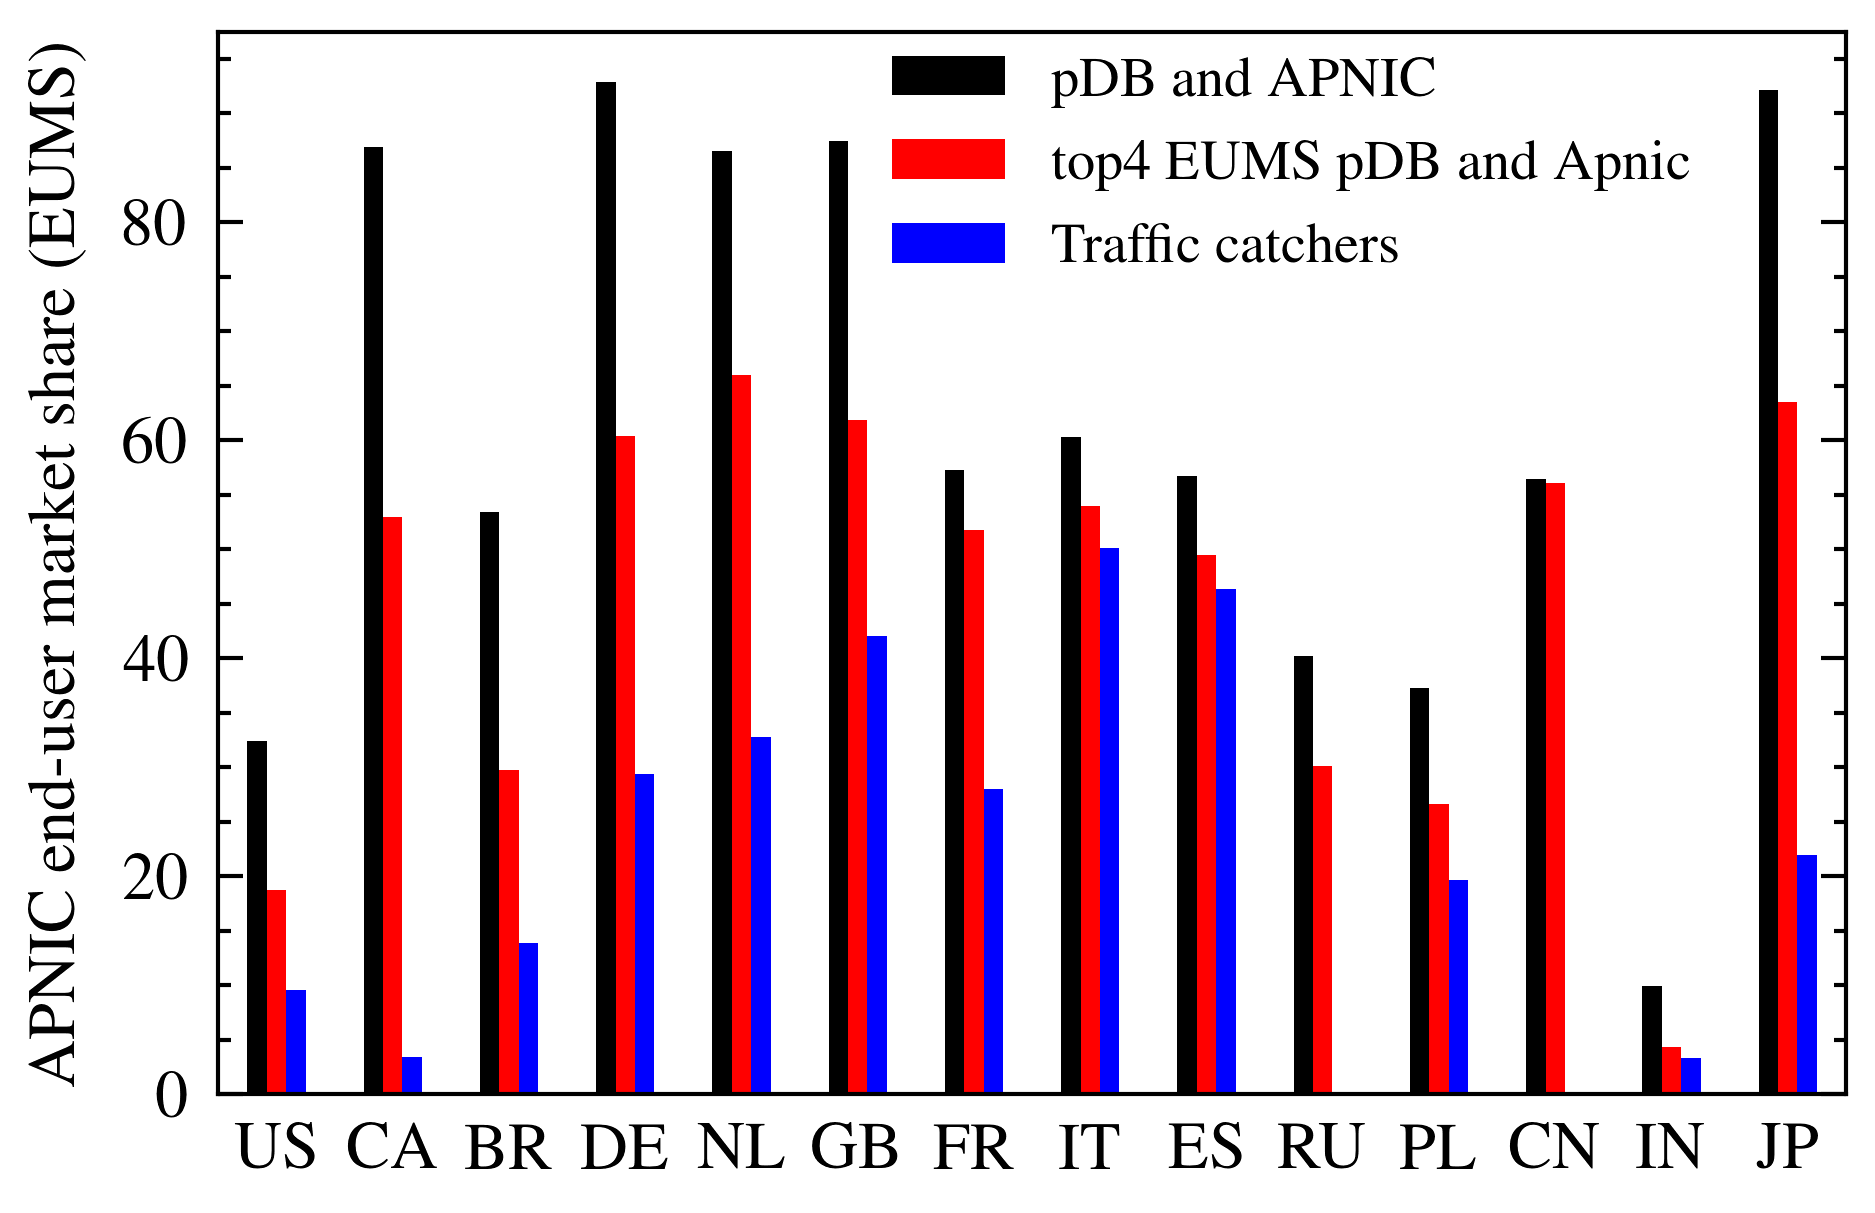

In [66]:
coverage[["pDB and Apnic Coverage", "top4 pDB and Apnic Coverage", "manual coverage"]].plot.bar(rot=0, figsize=(3.5,2.3))
plt.ylabel("APNIC end-user market share (EUMS)")
plt.legend(["pDB and APNIC", "top4 EUMS pDB and Apnic", "Traffic catchers"], fontsize=6.8, loc=(0.4,0.75))
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
) # labels along the bottom edge are off
plt.savefig("EUMS.pdf", bbox_inches="tight")

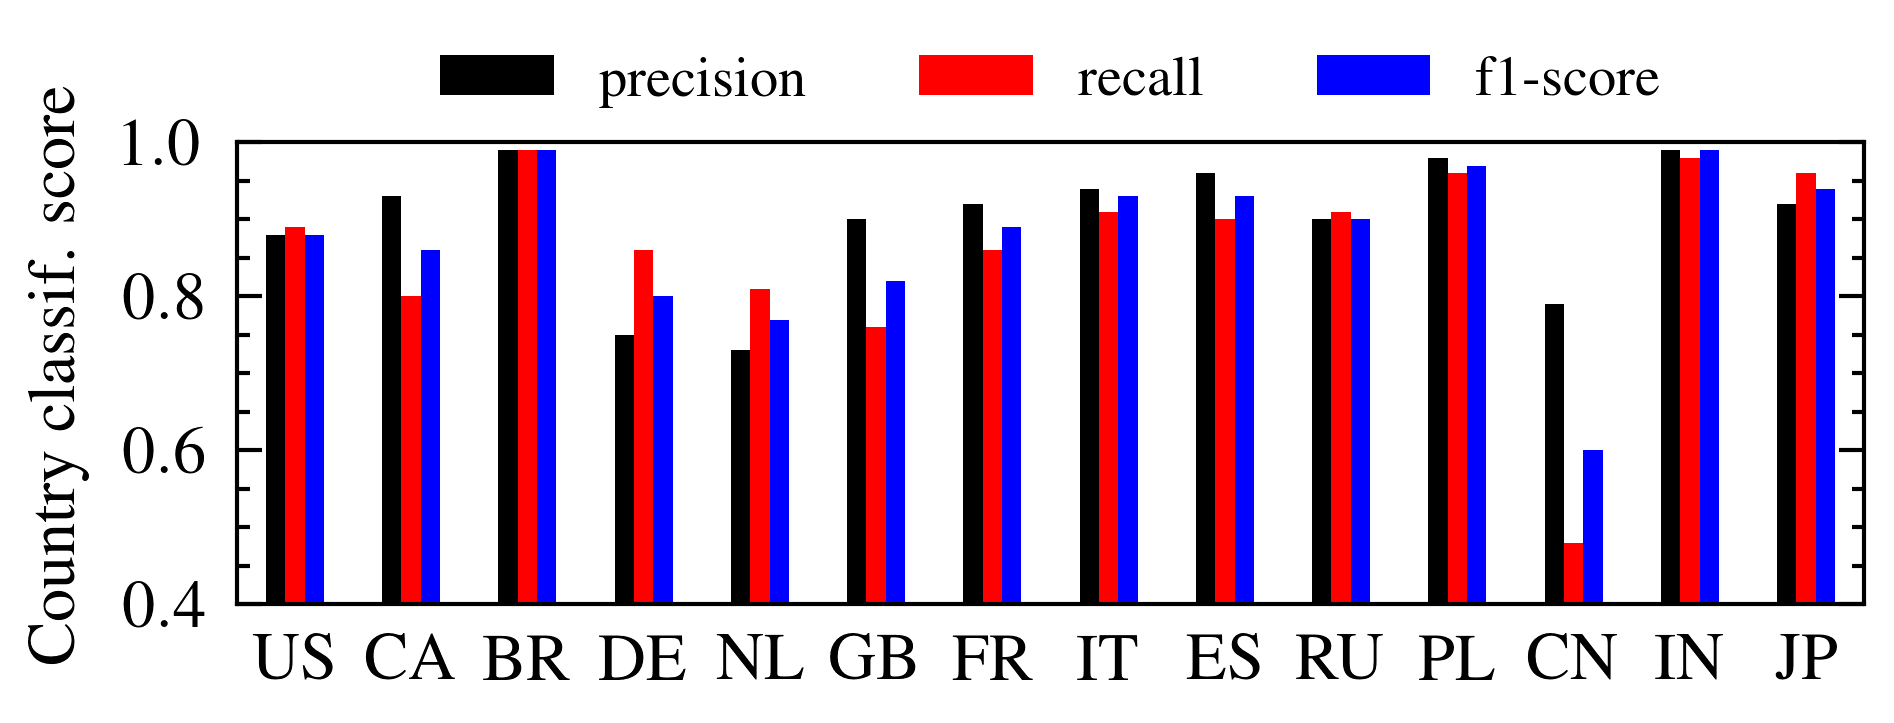

In [67]:
report.loc[countries_list,["precision", "recall", "f1-score"]].astype(float).plot.bar(rot=0, figsize=(3.5,1))
plt.ylabel("Country classif. score")
plt.gca().set_ylim([0.4,1.0])
plt.legend(["precision", "recall", "f1-score"], fontsize=6.8, ncol=3,
          loc="upper center" , borderaxespad=-2)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
) # labels along the bottom edge are off
plt.savefig("classif_metrics.pdf", bbox_inches="tight")

In [68]:
for col in coverage.columns:
    if coverage.dtypes[col] == float:
        coverage[col] = coverage[col].map(lambda x: format(x, ".2f"))
    
coverage.T

US     CA     BR     DE     NL     GB     FR  \
APNIC Coverage               96.61  99.49  94.57  99.36  99.67  99.39  99.67   
pDB and Apnic Coverage       32.46  86.88  53.44  92.84  86.55  87.44  57.27   
top4 pDB and Apnic Coverage  18.78  52.98  29.75  60.38  66.01  61.85  51.75   
ISP/ND coverage              13.67   3.44  13.84  24.32   7.81  43.98  28.09   
ISP/NSP/ND coverage           9.57   3.44  13.87  21.75  32.77  42.02  28.04   
manual coverage               9.57   3.44  13.87  29.38  32.77  42.02  28.04   

                                IT     ES     RU     PL     CN     IN     JP  
APNIC Coverage               99.55  99.72  98.24  99.11  99.85  99.24  99.69  
pDB and Apnic Coverage       60.28  56.75  40.25  37.25  56.44   9.96  92.12  
top4 pDB and Apnic Coverage  53.95  49.52  30.09  26.64  56.07   4.34  63.54  
ISP/ND coverage              13.23  45.07   0.71  15.82   0.01   3.32  14.54  
ISP/NSP/ND coverage          50.12  46.38   0.01  19.57   0.00   3.33  21.96  
manual coverage              50.12  46.38   0.01  19.65   0.00   3.33  21.96

In [69]:
coverage.to_csv("coverage_agg.csv")
coverage.T.to_csv("coverage_agg_horizontal.csv")

### Table 7 Traffic Receivers

In [70]:
countries_list = ["US", "BR", "DE", "NL", "GB", "FR", "IT", "ES", "PL", "JP"]

TableCatchers_paper = TableCatchers[["name", "country","rank", "apnic_country", "apnic_rank", "% of country"]]
TableCatchers_paper = TableCatchers_paper.loc[TableCatchers_paper.country.isin(countries_list)]

TableCatchers_paper.set_index("name", inplace = True)
TableCatchers_paper.columns = pd.MultiIndex.from_arrays([['PeeringDB', 'PeeringDB', 'APNIC', 'APNIC', 'APNIC'],
                                list(TableCatchers_paper.columns)])
# TableCatchers_paper.to_csv("Traffic_catchers_manual.csv")

In [71]:
TableCatchers_paper

PeeringDB              APNIC             \
                                      country rank apnic_country apnic_rank   
name                                                                          
T-Mobile USA                               US    1            US          2   
Claro S.A.                                 US    2            BR         24   
Zayo (Abovenet Communications Inc.)        US    3            US         44   
KDDI                                       US    4            JP          1   
Open X Tecnologia Ltda                     BR    1            BR         40   
G8                                         BR    2            BR         35   
Claro S.A. (NET)                           BR    3            BR          1   
Sistemax Brasil (Wiix Internet)            BR    4            BR         40   
Telefónica Germany GmbH & Co. OHG          DE    1            DE          3   
Vodafone Germany                           DE    2            DE          2   
Saudi Telecom Company (STC IGW)            DE    3            SA         17   
Vodafone Kabel Deutschland GmbH            DE    4            DE          5   
KPN-Netco                                  NL    1            NL          1   
BICS                                       NL    2            CN         39   
T-Mobile Thuis                             NL    3            NL          6   
Joint Transit                              NL    4           NaN       <NA>   
BTnet (BT's UK IP Network - AS2856)        GB    1            GB          3   
TalkTalk                                   GB    2            GB          5   
Sky Broadband                              GB    3            GB          1   
Hyperoptic                                 GB    4            GB         20   
Bouygues Telecom ISP                       FR    1            FR          4   
SFR Group                                  FR    2            FR          3   
Zayo France                                FR    3            FR         21   
moji                                       FR    4            FR         23   
WIND Telecomunicazioni S.p.A.              IT    1            IT          3   
NGI                                        IT    2            IT          8   
Fastweb                                    IT    3            IT          4   
Vodafone Italy                             IT    4            IT          2   
MásMóvil                                   ES    1            ES          4   
Orange Spain                               ES    2            ES          2   
Vodafone España                            ES    3            ES          3   
Aire Networks del Mediterraneo             ES    4            ES         10   
Netia S.A.                                 PL    1            PL          5   
VECTRA                                     PL    2            PL          6   
Polkomtel Sp. z o.o.                       PL    3            PL          2   
Korbank                                    PL    4            PL         26   
SoftBank Corp.                             JP    1            JP          2   
Level 3 AS 3356                            JP    2            US         39   
Colt                                       JP    3            DE         30   
BIGLOBE Inc.                               JP    4            JP          8   

                                                  
                                    % of country  
name                                              
T-Mobile USA                                9.53  
Claro S.A.                                  0.16  
Zayo (Abovenet Communications Inc.)         0.04  
KDDI                                       19.76  
Open X Tecnologia Ltda                      0.00  
G8                                          0.05  
Claro S.A. (NET)                           13.82  
Sistemax Brasil (Wiix Internet)             0.00  
Telefónica Germany GmbH & Co. OHG          10.14  
Vodafone Germany          

In [72]:
print(len(rnodes), len(rnodes_label))

76 76


### output: formatting for the paper and pickle for the next parts

**Output for the paper**
Hypergiants table

In [73]:
apnic["in_pdb"] = apnic.index.isin(nodes.index)
apnic["in_TrafficCatchers"] = apnic.index.isin(TableCatchers.asn)

We remove countries not represented in PeeringDB

In [74]:
countries_list = ["US", "BR", "DE", "NL", "GB", "FR", "IT", "ES", "PL", "JP"]
rnodes = rnodes[:topCR] + [rnode for rnode in rnodes[topCR:] if nodes_jan.loc[rnode, "country"] in countries_list]
nodes_jan.loc[rnodes]

print(len(rnodes), topCR + topK*len(countries_list))
assert len(rnodes) == topCR + topK*len(countries_list)

60 60


In [75]:
pd.set_option('display.max_rows', 100)
codes = [0] * len(rnodes[topCR:])
topKs = [topK] * len(countries_list)

count = 0 
for i in range(len(countries_list)):
    for j in range(topKs[i]):
        codes[count] = countries_list[i] + str(j+1)
        count += 1
        
TableCatchers = pd.DataFrame(index = codes)
TableCatchers["name"] = nodes_jan.loc[rnodes[topCR:], "name"].values
TableCatchers["asn"] = nodes_jan.loc[rnodes[topCR:]].index
TableCatchers["country"] = [code[:2] for code in codes]
TableCatchers["rank"] = [code[-1] for code in codes]
TableCatchers["type"] = nodes_jan.loc[rnodes[topCR:], "AStype"].values
# TableCatchers["name"].to_csv("Traffic_catchers.csv")
TableCatchers.head(50)

name     asn country rank           type
US1                         T-Mobile USA   21928      US    1  Cable/DSL/ISP
US2                           Claro S.A.    4230      US    2            NSP
US3  Zayo (Abovenet Communications Inc.)    6461      US    3            NSP
US4                                 KDDI    2516      US    4            NSP
BR1               Open X Tecnologia Ltda  263444      BR    1            NSP
BR2                                   G8   28329      BR    2            NSP
BR3                     Claro S.A. (NET)   28573      BR    3  Cable/DSL/ISP
BR4      Sistemax Brasil (Wiix Internet)  265950      BR    4  Not Disclosed
DE1    Telefónica Germany GmbH & Co. OHG    6805      DE    1            NSP
DE2                     Vodafone Germany    3209      DE    2  Cable/DSL/ISP
DE3      Saudi Telecom Company (STC IGW)   39386      DE    3            NSP
DE4      Vodafone Kabel Deutschland GmbH   31334      DE    4  Cable/DSL/ISP
NL1                            KPN-Netco    1136      NL    1            NSP
NL2                                 BICS    6774      NL    2            NSP
NL3                       T-Mobile Thuis   50266      NL    3  Cable/DSL/ISP
NL4                        Joint Transit   24785      NL    4            NSP
GB1  BTnet (BT's UK IP Network - AS2856)    2856      GB    1            NSP
GB2                             TalkTalk   13285      GB    2  Cable/DSL/ISP
GB3                        Sky Broadband    5607      GB    3  Cable/DSL/ISP
GB4                           Hyperoptic   56478      GB    4  Cable/DSL/ISP
FR1                 Bouygues Telecom ISP    5410      FR    1  Cable/DSL/ISP
FR2                            SFR Group   15557      FR    2  Cable/DSL/ISP
FR3                          Zayo France    8218      FR    3            NSP
FR4                                 moji  203698      FR    4  Cable/DSL/ISP
IT1        WIND Telecomunicazioni S.p.A.    1267      IT    1            NSP
IT2                                  NGI   35612      IT    2  Cable/DSL/ISP
IT3                              Fastweb   12874      IT    3  Cable/DSL/ISP
IT4                       Vodafone Italy   30722      IT    4            NSP
ES1                             MásMóvil   15704      ES    1  Cable/DSL/ISP
ES2                         Orange Spain   12479      ES    2               
ES3                      Vodafone España   12430      ES    3  Cable/DSL/ISP
ES4       Aire Networks del Mediterraneo   29119      ES    4            NSP
PL1                           Netia S.A.   12741      PL    1            NSP
PL2                               VECTRA   29314      PL    2  Cable/DSL/ISP
PL3                 Polkomtel Sp. z o.o.    8374      PL    3  Cable/DSL/ISP
PL4                              Korbank   35179      PL    4            NSP
JP1                       SoftBank Corp.   17676      JP    1            NSP
JP2                      Level 3 AS 3356    3356      JP    2            NSP
JP3                                 Colt    8220      JP    3            NSP
JP4                         BIGLOBE Inc.    2518      JP    4            NSP

In [76]:
apnic["in_pdb"] = apnic.index.isin(nodes.index)
apnic["in_TrafficCatchers"] = apnic.index.isin(TableCatchers.asn)

# apnic

From now on I need to work on APNIC without duplicates

In [77]:
if "asn" in apnic.columns:
    apnic.set_index("asn", inplace=True)
apnic.sort_values(by="Users (est.)", ascending=False, inplace=True)
apnic = apnic[~apnic.index.duplicated(keep='first')]

In [78]:
pd.set_option('display.max_rows', 500)

apnic["country_rank"] = apnic.groupby("CC")["% of country"].rank("dense", ascending=False).astype(int)

# display(apnic.sort_values(by=["CC", "% of country"], ascending=[True, False]))

topApnic = apnic.groupby("CC").head(10).loc[apnic.CC.isin(countries_list)]

topApnic.sort_values(by=["CC", "% of country"], ascending=[True, False]).to_csv("apnic_processed.csv")

def get_apnic_country_rank(AS):
    if AS.asn in apnic.index:
        apnic_entry = apnic.loc[AS.asn]
        return apnic_entry["CC"] + '_' + str(apnic_entry["country_rank"])
    else:
        return np.nan
    
# def get_apnic_country(AS):
#     if AS.asn in apnic.index:
#         apnic_entry = apnic.loc[AS.asn]
#         return apnic_entry["CC"]
#     else:
#         return np.nan
    
# def get_apnic_country(AS):
#     if AS.asn in apnic.index:
#         apnic_entry = apnic.loc[AS.asn]
#         return apnic_entry["CC"] + '_' + str(apnic_entry["country_rank"])
#     else:
#         return np.nan

TableCatchers["apnic_country_rank"] = TableCatchers.apply(get_apnic_country_rank, axis=1)
TableCatchers["% of country"] = TableCatchers.asn.map(apnic["% of country"])
TableCatchers["apnic_country"] = TableCatchers.asn.map(apnic["CC"])
TableCatchers["apnic_rank"] = TableCatchers.asn.map(apnic["country_rank"]).astype('Int64')

TableCatchers["AStype"] = TableCatchers.asn.map(nodes["AStype"])
display(TableCatchers.head(100))
# TableCatchers[["name", "apnic_country", "apnic_rank", "% of country"]].to_csv("Traffic_catchers_apnic_ISPs_ND.csv")

name     asn country rank           type  \
US1                         T-Mobile USA   21928      US    1  Cable/DSL/ISP   
US2                           Claro S.A.    4230      US    2            NSP   
US3  Zayo (Abovenet Communications Inc.)    6461      US    3            NSP   
US4                                 KDDI    2516      US    4            NSP   
BR1               Open X Tecnologia Ltda  263444      BR    1            NSP   
BR2                                   G8   28329      BR    2            NSP   
BR3                     Claro S.A. (NET)   28573      BR    3  Cable/DSL/ISP   
BR4      Sistemax Brasil (Wiix Internet)  265950      BR    4  Not Disclosed   
DE1    Telefónica Germany GmbH & Co. OHG    6805      DE    1            NSP   
DE2                     Vodafone Germany    3209      DE    2  Cable/DSL/ISP   
DE3      Saudi Telecom Company (STC IGW)   39386      DE    3            NSP   
DE4      Vodafone Kabel Deutschland GmbH   31334      DE    4  Cable/DSL/ISP   
NL1                            KPN-Netco    1136      NL    1            NSP   
NL2                                 BICS    6774      NL    2            NSP   
NL3                       T-Mobile Thuis   50266      NL    3  Cable/DSL/ISP   
NL4                        Joint Transit   24785      NL    4            NSP   
GB1  BTnet (BT's UK IP Network - AS2856)    2856      GB    1            NSP   
GB2                             TalkTalk   13285      GB    2  Cable/DSL/ISP   
GB3                        Sky Broadband    5607      GB    3  Cable/DSL/ISP   
GB4                           Hyperoptic   56478      GB    4  Cable/DSL/ISP   
FR1                 Bouygues Telecom ISP    5410      FR    1  Cable/DSL/ISP   
FR2                            SFR Group   15557      FR    2  Cable/DSL/ISP   
FR3                          Zayo France    8218      FR    3            NSP   
FR4                                 moji  203698      FR    4  Cable/DSL/ISP   
IT1        WIND Telecomunicazioni S.p.A.    1267      IT    1            NSP   
IT2                                  NGI   35612      IT    2  Cable/DSL/ISP   
IT3                              Fastweb   12874      IT    3  Cable/DSL/ISP   
IT4                       Vodafone Italy   30722      IT    4            NSP   
ES1                             MásMóvil   15704      ES    1  Cable/DSL/ISP   
ES2                         Orange Spain   12479      ES    2                  
ES3                      Vodafone España   12430      ES    3  Cable/DSL/ISP   
ES4       Aire Networks del Mediterraneo   29119      ES    4            NSP   
PL1                           Netia S.A.   12741      PL    1            NSP   
PL2                               VECTRA   29314      PL    2  Cable/DSL/ISP   
PL3                 Polkomtel Sp. z o.o.    8374      PL    3  Cable/DSL/ISP   
PL4                              Korbank   35179      PL    4            NSP   
JP1                       SoftBank Corp.   17676      JP    1            NSP   
JP2                      Level 3 AS 3356    3356      JP    2            NSP   
JP3                                 Colt    8220      JP    3            NSP   
JP4                         BIGLOBE Inc.    2518      JP    4            NSP   

    apnic_country_rank  % of country apnic_country  apnic_rank         AStype  
US1               US_2          9.53            US           2  Cable/DSL/ISP  
US2              BR_24          0.16            BR          24            NSP  
US3              US_44          0.04            US          44            NSP  
US4               JP_1         19.76            JP           1            NSP  
BR1              BR_40          0.00            BR          40            NSP  
BR2              BR_35          0.05            BR          35            NSP  
BR3               BR_1         13.82            BR           1  Cable/DSL/ISP  
BR4              BR_40          0.00            BR          40            NSP  
DE1               DE_3         10.1

I prettify this tables for the output

In [79]:
TableCatchers_paper = TableCatchers[["name", "country","rank", "apnic_country", "apnic_rank", "% of country"]]

In [80]:
TableCatchers_paper.head(10)

name country rank apnic_country  \
US1                         T-Mobile USA      US    1            US   
US2                           Claro S.A.      US    2            BR   
US3  Zayo (Abovenet Communications Inc.)      US    3            US   
US4                                 KDDI      US    4            JP   
BR1               Open X Tecnologia Ltda      BR    1            BR   
BR2                                   G8      BR    2            BR   
BR3                     Claro S.A. (NET)      BR    3            BR   
BR4      Sistemax Brasil (Wiix Internet)      BR    4            BR   
DE1    Telefónica Germany GmbH & Co. OHG      DE    1            DE   
DE2                     Vodafone Germany      DE    2            DE   

     apnic_rank  % of country  
US1           2          9.53  
US2          24          0.16  
US3          44          0.04  
US4           1         19.76  
BR1          40          0.00  
BR2          35          0.05  
BR3           1         13.82  
BR4          40          0.00  
DE1           3         10.14  
DE2           2         11.61

In [81]:
TableCatchers_paper.set_index("name", inplace = True)

In [82]:
TableCatchers_paper.head(10)

country rank apnic_country  apnic_rank  \
name                                                                         
T-Mobile USA                             US    1            US           2   
Claro S.A.                               US    2            BR          24   
Zayo (Abovenet Communications Inc.)      US    3            US          44   
KDDI                                     US    4            JP           1   
Open X Tecnologia Ltda                   BR    1            BR          40   
G8                                       BR    2            BR          35   
Claro S.A. (NET)                         BR    3            BR           1   
Sistemax Brasil (Wiix Internet)          BR    4            BR          40   
Telefónica Germany GmbH & Co. OHG        DE    1            DE           3   
Vodafone Germany                         DE    2            DE           2   

                                     % of country  
name                                               
T-Mobile USA                                 9.53  
Claro S.A.                                   0.16  
Zayo (Abovenet Communications Inc.)          0.04  
KDDI                                        19.76  
Open X Tecnologia Ltda                       0.00  
G8                                           0.05  
Claro S.A. (NET)                            13.82  
Sistemax Brasil (Wiix Internet)              0.00  
Telefónica Germany GmbH & Co. OHG           10.14  
Vodafone Germany                            11.61

In [83]:
TableCatchers_paper.columns = pd.MultiIndex.from_arrays([['PeeringDB', 'PeeringDB', 'APNIC', 'APNIC', 'APNIC'],
                                list(TableCatchers_paper.columns)])

In [84]:
TableCatchers_paper.to_csv("Traffic_catchers_apnic_ISPs_ND.csv")

In [85]:
TrafficCatchersCoverage = TableCatchers.groupby("apnic_country").sum()["% of country"]
TrafficCatchersCoverage

apnic_country
BR    14.03
CN     0.00
DE    29.47
ES    46.38
FR    28.04
GB    42.02
IT    50.12
JP    41.72
NL    32.77
PL    19.65
SA     0.00
US     9.66
Name: % of country, dtype: float64

**We can compare it to our end-users market share**

In [86]:
# TableCatchers_paper.groupby(("APNIC","apnic_country")).sum()["% of country"]

**Formatting of the nodes label**

In [87]:
rnodes_label = list(nodes_jan.loc[rnodes,"name"])
rnodes_label

['Facebook Inc',
 'Amazon.com',
 'Akamai Technologies',
 'Google LLC',
 'Apple Inc.',
 'Microsoft',
 'Netflix',
 'Cloudflare',
 'StackPath (Highwinds)',
 'Hurricane Electric',
 'Fastly, Inc.',
 'Verizon Digital Media Services (EdgeCast Networks)',
 'OVHcloud',
 'Limelight Networks Global',
 'Yahoo!',
 'Valve Corporation',
 'Twitch',
 'Tencent Global',
 'Twitter, Inc.',
 'CABASE-RCN',
 'T-Mobile USA',
 'Claro S.A.',
 'Zayo (Abovenet Communications Inc.)',
 'KDDI',
 'Open X Tecnologia Ltda',
 'G8',
 'Claro S.A. (NET)',
 'Sistemax Brasil (Wiix Internet)',
 'Telefónica Germany GmbH & Co. OHG',
 'Vodafone Germany',
 'Saudi Telecom Company (STC IGW)',
 'Vodafone Kabel Deutschland GmbH',
 'KPN-Netco',
 'BICS',
 'T-Mobile Thuis',
 'Joint Transit',
 "BTnet (BT's UK IP Network - AS2856)",
 'TalkTalk',
 'Sky Broadband',
 'Hyperoptic',
 'Bouygues Telecom ISP',
 'SFR Group',
 'Zayo France',
 'moji',
 'WIND Telecomunicazioni S.p.A.',
 'NGI',
 'Fastweb',
 'Vodafone Italy',
 'MásMóvil',
 'Orange Spain

In [88]:
latexlabels = ['Facebook',
 'Amazon',
 'Akamai',
 'Google',
 'Apple',
 'Microsoft',
 'Netflix',
 'Cloudflare',
 'StackPath',
 'Hurricane Electric',
 'Fastly',
 'Edgecast',
 'OVHcloud',
 'Limelight Net. Global',
 'Yahoo!',
 'Valve',
 'Twitch',
 'Tencent Global',
 'Twitter',
 'CABASE-RCN',
 'T-Mobile USA',
 'Claro S.A.',
 'Zayo',
 'KDDI',
 'Open X Tecnologia',
 'G8',
 'Claro S.A. (NET)',
 'Sistemax Brasil',
 'Telefónica DE',
 'Vodafone DE',
 'Saudi Telecom Company',
 'Vodafone Kabel DE',
 'KPN-Netco',
 'BICS',
 'T-Mobile Thuis',
 'Joint Transit',
 "BTnet",
 'TalkTalk',
 'Sky Broadband',
 'Hyperoptic',
 'Bouygues Telecom ISP',
 'SFR Group',
 'Zayo France',
 'moji',
 'WIND Telecom.',
 'NGI',
 'Fastweb',
 'Vodafone Italy',
 'MásMóvil',
 'Orange Spain',
 'Vodafone España',
 'Aire Networks del M.',
 'Netia S.A.',
 'VECTRA',
 'Polkomtel',
 'Korbank',
 'SoftBank',
 'Level 3 AS 3356',
 'Colt',
 'BIGLOBE']

latexlabels = [element.replace("&", "\&") for element in latexlabels]
latexlabels = [element.replace("_", "\_") for element in latexlabels]

In [89]:
countries_list = ["US", "BR", "DE", "NL", "GB", "FR", "IT", "ES", "PL", "JP"]

TableCatchers_paper = TableCatchers[["name", "country","rank", "apnic_country", "apnic_rank", "% of country"]]
TableCatchers_paper["name"] = TableCatchers_paper["name"].map({rnode_label:latexlabel for (rnode_label,latexlabel) in zip(rnodes_label,latexlabels) })
TableCatchers_paper = TableCatchers_paper.loc[TableCatchers_paper.country.isin(countries_list)]

TableCatchers_paper.set_index("name", inplace = True)
TableCatchers_paper.columns = pd.MultiIndex.from_arrays([['PeeringDB', 'PeeringDB', 'APNIC', 'APNIC', 'APNIC'],
                                list(TableCatchers_paper.columns)])
TableCatchers_paper.to_csv("Traffic_catchers_manual.csv")

/home/justin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [90]:
TableCatchers_paper

PeeringDB              APNIC                        
                        country rank apnic_country apnic_rank % of country
name                                                                      
T-Mobile USA                 US    1            US          2         9.53
Claro S.A.                   US    2            BR         24         0.16
Zayo                         US    3            US         44         0.04
KDDI                         US    4            JP          1        19.76
Open X Tecnologia            BR    1            BR         40         0.00
G8                           BR    2            BR         35         0.05
Claro S.A. (NET)             BR    3            BR          1        13.82
Sistemax Brasil              BR    4            BR         40         0.00
Telefónica DE                DE    1            DE          3        10.14
Vodafone DE                  DE    2            DE          2        11.61
Saudi Telecom Company        DE    3            SA         17         0.00
Vodafone Kabel DE            DE    4            DE          5         7.63
KPN-Netco                    NL    1            NL          1        29.85
BICS                         NL    2            CN         39         0.00
T-Mobile Thuis               NL    3            NL          6         2.92
Joint Transit                NL    4           NaN       <NA>          NaN
BTnet                        GB    1            GB          3        16.77
TalkTalk                     GB    2            GB          5         5.77
Sky Broadband                GB    3            GB          1        19.21
Hyperoptic                   GB    4            GB         20         0.27
Bouygues Telecom ISP         FR    1            FR          4        13.65
SFR Group                    FR    2            FR          3        14.37
Zayo France                  FR    3            FR         21         0.02
moji                         FR    4            FR         23         0.00
WIND Telecom.                IT    1            IT          3        17.02
NGI                          IT    2            IT          8         1.37
Fastweb                      IT    3            IT          4        10.44
Vodafone Italy               IT    4            IT          2        21.29
MásMóvil                     ES    1            ES          4         6.35
Orange Spain                 ES    2            ES          2        24.92
Vodafone España              ES    3            ES          3        13.63
Aire Networks del M.         ES    4            ES         10         1.48
Netia S.A.                   PL    1            PL          5         3.92
VECTRA                       PL    2            PL          6         3.38
Polkomtel                    PL    3            PL          2        12.27
Korbank                      PL    4            PL         26         0.08
SoftBank                     JP    1            JP          2        19.23
Level 3 AS 3356              JP    2            US         39         0.09
Colt                         JP    3            DE         30         0.09
BIGLOBE                      JP    4            JP          8         2.73

**Output for the next part**

In [91]:
pickle_out = open("caida_pdbs/processed/clustered/rnodes.pickle","wb")
# pickle.dump([rnodes, rnodes_label], pickle_out)
pickle.dump([rnodes, latexlabels], pickle_out)
pickle_out.close()

##for the article we consider topCR = 20 and topK = 4.
##However with the rnodes merging of the two dates, this number slightly change
pickle_out = open("caida_pdbs/processed/clustered/rparams.pickle","wb")
pickle.dump([topCR, topKs, countries_list], pickle_out)
pickle_out.close()

# pickle_out = open("caida_pdbs/processed/clustered/rparams.pickle","wb")
# pickle.dump([topCR, topKs, countries_list], pickle_out)
# pickle_out.close()

pickle_out = open("caida_pdbs/processed/clustered/peeringdb_2_dump_2020_01_01.pickle","wb")
pickle.dump([net_jan, ix_jan, nodes_jan, DiGraph_jan], pickle_out)
pickle_out.close()

pickle_out = open("caida_pdbs/processed/clustered/peeringdb_2_dump_2020_06_01.pickle","wb")
pickle.dump([net, ix, nodes, DiGraph], pickle_out)
pickle_out.close()

nodes_jan.to_csv("caida_pdbs/processed/clustered/nodes_peeringdb_2_dump_2020_01_01.csv")
ix_jan.to_csv("caida_pdbs/processed/clustered/ix_peeringdb_2_dump_2020_01_01.csv")
net_jan.to_csv("caida_pdbs/processed/clustered/net_peeringdb_2_dump_2020_01_01.csv")

# Hypergiants to eyeball diffusion patterns

In [92]:
from pygomax import pygomax

def plot_G(ax, reduced_matrix, rnodes, rnodes_label, name, cmap_range=[]):
    """
    Plot a reduced_matrix.
    """
    
    ax.title.set_text(name+" = " + format(np.sum(reduced_matrix)/reduced_matrix.shape[0], ".6f"))
    if len(cmap_range) == 0:
        cmap_range = [np.min(reduced_matrix), np.max(reduced_matrix)]
    
    norm = mpl.colors.Normalize(vmin=cmap_range[0], vmax=cmap_range[1])
    cmap_obj = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    cmap = cmap_obj.cmap
    cm = ax.imshow(reduced_matrix, cmap="viridis")
    
    ax.set_xticks([i for i in range(reduced_matrix.shape[0])])
    ax.set_xticklabels(rnodes_label, rotation="90")
    ax.set_yticks([i for i in range(reduced_matrix.shape[0])])
    ax.set_yticklabels(rnodes_label)
    
    return cm

In [93]:
pickle_in = open("caida_pdbs/processed/clustered/rnodes.pickle","rb")
rnodes, rnodes_label = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("caida_pdbs/processed/clustered/rparams.pickle", "rb")
topCR, topKs, countries_list = pickle.load(pickle_in)
pickle_in.close()

assert len(rnodes) == topCR + np.sum(topKs)

In [94]:
Gmatrix = pygomax.GoogleMatrix(data=DiGraph_jan, weighted=True)
GmatrixStar = pygomax.GoogleMatrix(data=DiGraph_jan.reverse(), weighted=True)

In [95]:
Grr, Gpr, Gqr = pygomax.regomax(GmatrixStar, rnodes=rnodes, maxiter = 801)

Weight of Grr is  0.0008669685001444947
Weight of Gpr is  0.4496400582505282
Weight of Gqr is  0.5494929732493254
Weight of GR is  0.9999999999999981


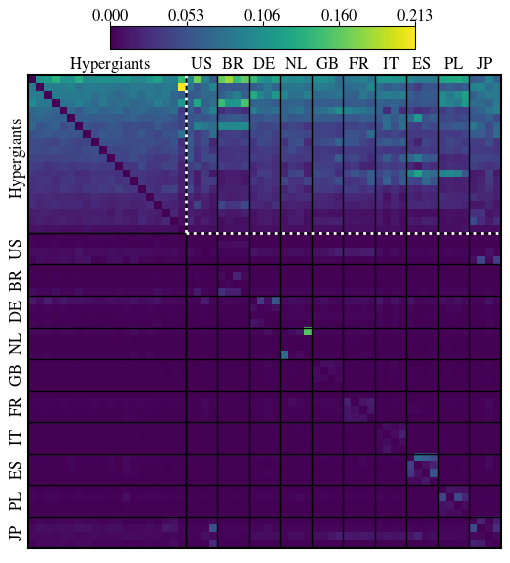

In [96]:
import matplotlib as mpl
from matplotlib import ticker

plt.style.use('default')


Gqr = Grr + Gpr + Gqr
for i in range(len(rnodes)):
    Gqr[i,i] = 0.0
    Gqr[:,i] /= np.sum(Gqr[:,i])


## change rnodes label for publication friendly
## latex symbols
latexlabels = [element.replace("&", "\&") for element in rnodes_label]
latexlabels = [element.replace("_", "\_") for element in latexlabels]


fig = plt.figure(figsize=(6.1,6.1))
ax = fig.add_subplot(111)
cm = plot_G(ax, Gqr, rnodes, latexlabels, "Gqr")
ax.title.set_text('')


ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])


plt.setp(ax.spines.values(), linewidth=1.5)
plt.vlines([topCR-0.5] + [topCR-0.5+sum(topKs[:i]) for i in range(len(countries_list))],-0.5,len(rnodes)-0.5, linewidth=1.0, colors='black')
plt.hlines([topCR-0.5] + [topCR-0.5+sum(topKs[:i]) for i in range(len(countries_list))],-0.5,len(rnodes)-0.5, linewidth=1.0, colors='black')

plt.vlines([topCR-0.5],-0.5,topCR-0.5, linewidth=2.0, linestyles="dotted", colors=["white"])
plt.hlines([topCR-0.5],topCR-0.5, len(rnodes)-0.5, linewidth=2.0, linestyles="dotted", colors=["white"])


plt.rc('font',**{'family':'serif','serif':['Times'], 'size':12})
plt.rc('text', usetex=True)

###horizontal annotation
annotations_label = ["Hypergiants"] + countries_list
annotations_pos = [0.5*topCR] + [topCR-0.5+sum(topKs[:i])+0.5*topKs[i] for i in range(len(countries_list))]
for i in range(len(countries_list) + 1):
    ax.annotate(annotations_label[i], (annotations_pos[i],-1.4), annotation_clip=False, ha="center")

###vertical annotation
annotations_label = ["Hypergiants"] + countries_list
annotations_pos = [0.5*topCR] + [topCR-0.5+sum(topKs[:i])+0.5*topKs[i] for i in range(len(countries_list))]
for i in range(len(countries_list) + 1):
    ax.annotate(annotations_label[i], (-2.8,annotations_pos[i]), annotation_clip=False, va="center", rotation=90)

##vertical colobar    
# fig.subplots_adjust(right=0.98)
# cbar_ax = fig.add_axes([0.95, 0.25, 0.038, 0.5])

##horizontal colobar    
fig.subplots_adjust(top=0.97)
cbar_ax = fig.add_axes([0.26,0.97, 0.5, 0.038])


cbar = fig.colorbar(cm, cax=cbar_ax, 
                   ticks =ticker.LinearLocator(5), orientation = "horizontal")

def format_func(value, tick_number):
    """
    use to round small negative value to 0.000 instead of -0.000 (purely style)
    """
    return format(abs(value), ".3f")

cbar_ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
cbar_ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
cbar_ax.xaxis.set_ticks_position("top")
cbar_ax.tick_params(axis='both', which='major', pad=-2)

plt.savefig("regomax_countries.pdf", bbox_inches="tight")